# Natural Language Processing with Disaster Tweets

**Brief Description**: This project describes my participation in the Kaggle competition "Natural Language Processing with Disaster Tweets" . Please refer to this [URL for the competition details](https://www.kaggle.com/competitions/nlp-getting-started/overview).

**Goal**:
1. Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
2. Aim for the highest possible score within the limited time and computing resources.
3. Learn deep learning, RNN, and NLP workflow.

**Time**: One week

**Computing resources**: Google colab pro with support of high RAM and T4 or A100 GPU.

**Model selection**:
* TF-IDF + Logistic Regression
* GRU + Attention
* transformer


---
## 1. Setup & Configuration

In [125]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# NLP & ML
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# PyTorch Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Download NLTK data (run once)
try:
    stopwords.words('english')
except:
    nltk.download('stopwords', quiet=True)

# Temporary random seed initialization (will be overridden by set_seed() after Config definition)
# This ensures reproducibility even before Config class is loaded
TEMP_SEED = 42
np.random.seed(TEMP_SEED)
torch.manual_seed(TEMP_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(TEMP_SEED)
    torch.backends.cudnn.deterministic = True

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print("✓ All libraries imported successfully!")




✓ PyTorch version: 2.9.0+cu126
✓ Device: cuda
✓ GPU: NVIDIA A100-SXM4-40GB
✓ GPU Memory: 39.56 GB
✓ All libraries imported successfully!


In [126]:
# Configuration - Centralized hyperparameters for 4-Layer NLP Architecture
class Config:
    # ========== General Configuration ==========
    RANDOM_SEED = 42
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # ========== Data Paths ==========
    GITHUB_REPO = 'https://raw.githubusercontent.com/RockDeng110/Natural-Language-Processing-with-Disaster-Tweets/main/data/raw/'
    TRAIN_URL = GITHUB_REPO + 'train.csv'
    TEST_URL = GITHUB_REPO + 'test.csv'
    SAMPLE_SUBMISSION_URL = GITHUB_REPO + 'sample_submission.csv'

    # Local paths
    MODEL_SAVE_DIR = './models'
    SUBMISSION_DIR = './data/submissions'
    GLOVE_PATH = './data/embeddings/glove.twitter.27B.200d.txt'

    # ========== Data Preprocessing ==========
    MAX_VOCAB_SIZE = 10000
    VALIDATION_SPLIT = 0.2

    # ========== Layer 0: Baseline (TF-IDF + Logistic Regression) ==========
    # No specific hyperparameters needed

    # ========== Layer 2: Seq2Seq + Attention (GRU + GloVe) ==========
    SEQ2SEQ_MAX_LEN = 50
    SEQ2SEQ_EMBEDDING_DIM = 200  # GloVe Twitter 200d
    SEQ2SEQ_HIDDEN_DIM = 128
    SEQ2SEQ_NUM_LAYERS = 2
    SEQ2SEQ_DROPOUT = 0.3
    SEQ2SEQ_BATCH_SIZE = 64
    SEQ2SEQ_EPOCHS = 20
    SEQ2SEQ_LEARNING_RATE = 0.001

    # ========== Layer 3: Transformers ==========
    TRANSFORMER_MAX_LEN = 128
    TRANSFORMER_BATCH_SIZE = 128  # Increased from 16 to 128 for A100 optimization
    TRANSFORMER_EPOCHS = 4
    TRANSFORMER_LEARNING_RATE = 2e-5
    TRANSFORMER_WARMUP_STEPS = 500
    TRANSFORMER_WEIGHT_DECAY = 0.01

    # Transformer model names
    ROBERTA_MODEL = 'roberta-base'
    DISTILBERT_MODEL = 'distilbert-base-uncased'
    DEBERTA_MODEL = 'microsoft/deberta-v3-base'

    # ========== Layer 4: LLM + LoRA (Qwen2.5) ==========
    # Switched from Llama-3 to Qwen2.5 due to gating restrictions
    LLAMA_MODEL = 'Qwen/Qwen2.5-7B-Instruct'
    LLM_MAX_LEN = 256
    LLM_BATCH_SIZE = 4
    LLM_EPOCHS = 3
    LLM_LEARNING_RATE = 1e-4
    LLM_WARMUP_RATIO = 0.03
    LLM_WEIGHT_DECAY = 0.01

    # LoRA configuration
    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q_proj", "v_proj"]

config = Config()
print("✓ Configuration loaded")
print(f"   Device: {config.DEVICE}")
print(f"   Random Seed: {config.RANDOM_SEED}")
print(f"   Validation Split: {config.VALIDATION_SPLIT}")
print(f"\n📊 Model Configurations:")
print(f"   Layer 1 (Baseline): TF-IDF + Logistic Regression")
print(f"   Layer 2 (Seq2Seq): Batch={config.SEQ2SEQ_BATCH_SIZE}, Epochs={config.SEQ2SEQ_EPOCHS}, Hidden={config.SEQ2SEQ_HIDDEN_DIM}")
print(f"   Layer 3 (Transformer): Batch={config.TRANSFORMER_BATCH_SIZE}, Epochs={config.TRANSFORMER_EPOCHS}, Models={config.ROBERTA_MODEL}")
print(f"   Layer 4 (LLM): Model={config.LLAMA_MODEL}, Batch={config.LLM_BATCH_SIZE}, LoRA r={config.LORA_R}")

✓ Configuration loaded
   Device: cuda
   Random Seed: 42
   Validation Split: 0.2

📊 Model Configurations:
   Layer 1 (Baseline): TF-IDF + Logistic Regression
   Layer 2 (Seq2Seq): Batch=64, Epochs=20, Hidden=128
   Layer 3 (Transformer): Batch=128, Epochs=4, Models=roberta-base
   Layer 4 (LLM): Model=Qwen/Qwen2.5-7B-Instruct, Batch=4, LoRA r=8


In [127]:
# Unified Random Seed Configuration Function
def set_seed(seed=None):
    """
    Set random seeds for reproducibility across all libraries.
    
    Args:
        seed: Random seed value. If None, uses config.RANDOM_SEED
    """
    if seed is None:
        seed = config.RANDOM_SEED
    
    # Python random
    import random
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    
    # PyTorch CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Transformers (if imported)
    try:
        from transformers import set_seed as transformers_set_seed
        transformers_set_seed(seed)
    except ImportError:
        pass
    
    print(f"✓ Random seed set to {seed} for all libraries")

# Apply unified random seed
config = Config()
set_seed()


✓ Random seed set to 42 for all libraries


---
## 2. Data Loading & Basic Understanding

### 2.1 **Load data**

In [128]:
# Download and load data
import requests
import os

# Create data directory
data_dir = './data/'
os.makedirs(data_dir, exist_ok=True)

# Create submissions directory if it doesn't exist
submissions_dir = './data/submissions'
os.makedirs(submissions_dir, exist_ok=True)

def download_file(url, filename):
    """Download file from URL"""
    filepath = os.path.join(data_dir, filename)
    if not os.path.exists(filepath):
        print(f"📥 Downloading {filename}...")
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()
            with open(filepath, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"✅ Downloaded {filename}")
        except requests.exceptions.RequestException as e:
            print(f"❌ Error downloading {filename}: {e}")
            return None
    else:
        print(f"✓ {filename} already exists")
    return filepath

# Download datasets
print("=" * 60)
print("DOWNLOADING DATASETS")
print("=" * 60)
train_filepath = download_file(config.TRAIN_URL, 'train.csv')
test_filepath = download_file(config.TEST_URL, 'test.csv')
submission_filepath = download_file(config.SAMPLE_SUBMISSION_URL, 'sample_submission.csv')

# Load data
if train_filepath and test_filepath:
    train_df = pd.read_csv(train_filepath)
    test_df = pd.read_csv(test_filepath)
    sample_submission_df = pd.read_csv(submission_filepath)
    print("\n✅ All datasets loaded successfully!")
else:
    print("\n❌ Failed to load datasets")
    raise Exception("Dataset loading failed")

DOWNLOADING DATASETS
✓ train.csv already exists
✓ test.csv already exists
✓ sample_submission.csv already exists

✅ All datasets loaded successfully!


### 2.2 **Ddatasets Overview**

In [129]:
# Basic dataset information
print("\n" + "=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

# 1. Dataset dimensions
print("\n📊 Dataset Dimensions:")
print(f"   Training set:   {train_df.shape[0]:,} samples × {train_df.shape[1]} features")
print(f"   Test set:       {test_df.shape[0]:,} samples × {test_df.shape[1]} features")
print(f"   Submission:     {sample_submission_df.shape[0]:,} samples × {sample_submission_df.shape[1]} columns")

# 2. Field descriptions
print("\n📋 Dataset Schema:")
print(f"   Training columns: {train_df.columns.tolist()}")
print(f"   Test columns:     {test_df.columns.tolist()}")

print("\n   Field descriptions:")
print("   - id:       Unique identifier for each tweet")
print("   - keyword:  A keyword from the tweet (may be blank)")
print("   - location: Location the tweet was sent from (may be blank)")
print("   - text:     The actual tweet text")
print("   - target:   Binary label (1 = disaster, 0 = not disaster) [Training only]")

# 3. Data types
print("\n🔢 Data Types:")
print(train_df.dtypes)

# 4. Memory usage
print(f"\n💾 Memory Usage:")
print(f"   Training set: {train_df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"   Test set:     {test_df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")


DATASET OVERVIEW

📊 Dataset Dimensions:
   Training set:   7,613 samples × 5 features
   Test set:       3,263 samples × 4 features
   Submission:     3,263 samples × 2 columns

📋 Dataset Schema:
   Training columns: ['id', 'keyword', 'location', 'text', 'target']
   Test columns:     ['id', 'keyword', 'location', 'text']

   Field descriptions:
   - id:       Unique identifier for each tweet
   - keyword:  A keyword from the tweet (may be blank)
   - location: Location the tweet was sent from (may be blank)
   - text:     The actual tweet text
   - target:   Binary label (1 = disaster, 0 = not disaster) [Training only]

🔢 Data Types:
id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

💾 Memory Usage:
   Training set: 2.02 MB
   Test set:     0.84 MB


### 2.3 **Data Samples**

In [130]:
# Data sample display
print("\n" + "=" * 60)
print("DATA SAMPLES")
print("=" * 60)

print("\n📝 Training Set - First 3 rows:")
print(train_df.head(3).to_string())

print("\n\n📝 Test Set - First 3 rows:")
print(test_df.head(3).to_string())

print("\n\n📝 Sample Submission Format:")
print(sample_submission_df.head(3).to_string())



DATA SAMPLES

📝 Training Set - First 3 rows:
   id keyword location                                                                                                                                   text  target
0   1     NaN      NaN                                                                  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1   4     NaN      NaN                                                                                                 Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected       1


📝 Test Set - First 3 rows:
   id keyword location                                                                                              text
0   0     NaN      NaN                                                                Just happened a terrible car crash
1   2     NaN      

---
## 3. Exploratory Data Analysis (EDA)


### 3.1 **Data balence analysis**

1. TARGET DISTRIBUTION ANALYSIS

📊 Class Distribution:
   Not Disaster (0): 4,342 samples (57.03%)
   Disaster (1):     3,271 samples (42.97%)

   Imbalance ratio: 1.33:1
   ✅ Dataset is well-balanced!


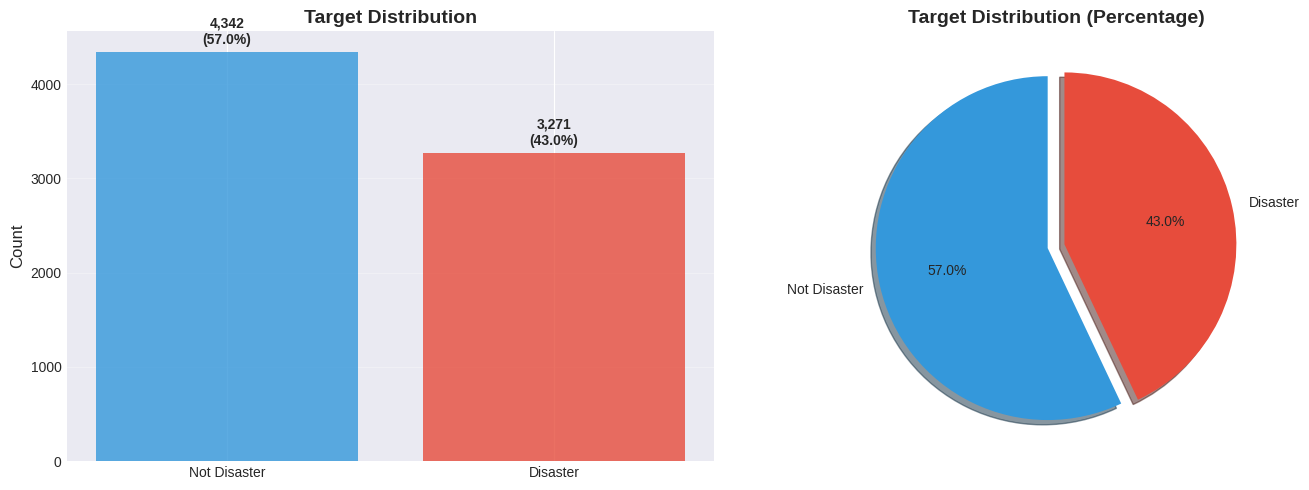


💡 Key Insight: Dataset is relatively balanced (43% disaster vs 57% not disaster)
💡 Implication: No need for special handling like SMOTE or class weights


In [131]:
# EDA 1: Target distribution analysis (Is the dataset balanced?)
print("=" * 60)
print("1. TARGET DISTRIBUTION ANALYSIS")
print("=" * 60)

# Target distribution statistics
target_counts = train_df['target'].value_counts().sort_index()
print("\n📊 Class Distribution:")
print(f"   Not Disaster (0): {target_counts[0]:,} samples ({target_counts[0]/len(train_df):.2%})")
print(f"   Disaster (1):     {target_counts[1]:,} samples ({target_counts[1]/len(train_df):.2%})")

# Calculate imbalance ratio
imbalance_ratio = target_counts.max() / target_counts.min()
print(f"\n   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio < 1.5:
    print("   ✅ Dataset is well-balanced!")
elif imbalance_ratio < 3:
    print("   ⚠️  Slight imbalance, but acceptable")
else:
    print("   ❌ Significant class imbalance - consider resampling or class weights")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
axes[0].bar(['Not Disaster', 'Disaster'], target_counts, color=['#3498db', '#e74c3c'], alpha=0.8)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, (label, count) in enumerate(zip(['Not Disaster', 'Disaster'], target_counts)):
    axes[0].text(i, count + 50, f'{count:,}\n({count/len(train_df):.1%})',
                 ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0.05)
axes[1].pie(target_counts, labels=['Not Disaster', 'Disaster'], autopct='%1.1f%%',
            colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Target Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Dataset is relatively balanced (43% disaster vs 57% not disaster)")
print("💡 Implication: No need for special handling like SMOTE or class weights")

### 3.2 **Missing value analysis**


2. MISSING VALUES ANALYSIS

📊 Training Set Missing Values:
          Missing Count  Percentage
keyword              61        0.80
location           2533       33.27

📊 Test Set Missing Values:
          Missing Count  Percentage
keyword              26        0.80
location           1105       33.86


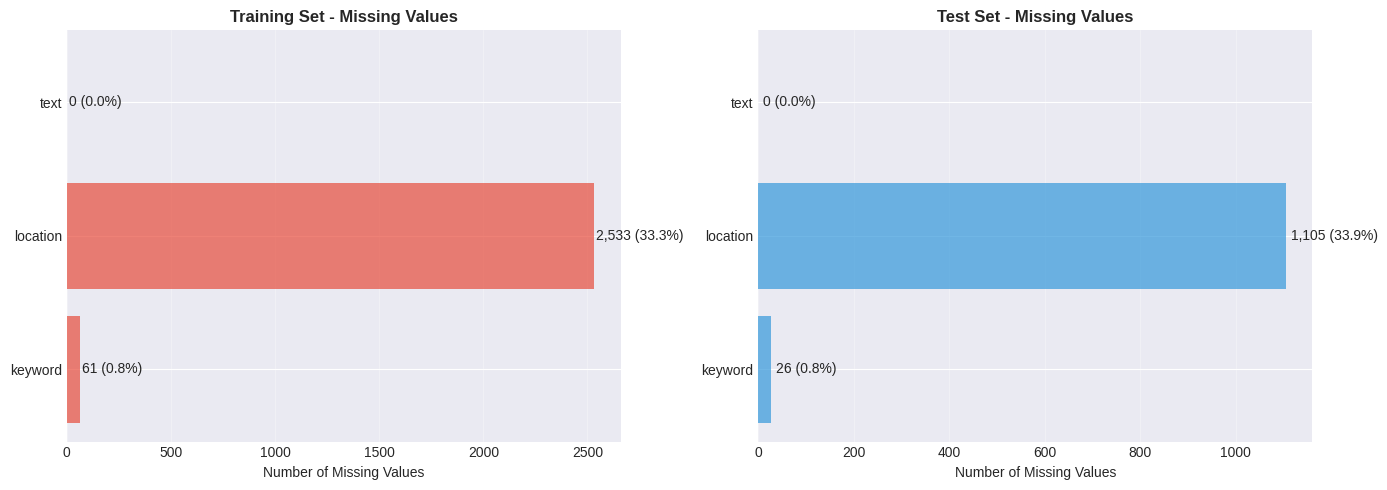


🔍 Impact of Missing Values on Target:

   Keyword:
      Disaster rate (with keyword):    42.76%
      Disaster rate (without keyword): 68.85%
      Difference: 26.10%

   Location:
      Disaster rate (with location):    43.23%
      Disaster rate (without location): 42.44%
      Difference: 0.79%

💡 Key Insight: ~0.8% samples missing keyword, ~33% missing location
💡 Strategy: keyword is important (61% coverage), location is very sparse
💡 Recommendation: Use keyword as feature, consider dropping location or treating as 'unknown'


In [132]:
# EDA 2: Missing values analysis
print("\n" + "=" * 60)
print("2. MISSING VALUES ANALYSIS")
print("=" * 60)

# Training set missing values statistics
print("\n📊 Training Set Missing Values:")
missing_train = train_df.isnull().sum()
missing_train_pct = (missing_train / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Percentage': missing_train_pct
})
print(missing_df[missing_df['Missing Count'] > 0].to_string())

# Test set missing values statistics
print("\n📊 Test Set Missing Values:")
missing_test = test_df.isnull().sum()
missing_test_pct = (missing_test / len(test_df) * 100).round(2)
missing_df_test = pd.DataFrame({
    'Missing Count': missing_test,
    'Percentage': missing_test_pct
})
print(missing_df_test[missing_df_test['Missing Count'] > 0].to_string())

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set missing values
fields_train = ['keyword', 'location', 'text']
missing_counts_train = [train_df[col].isnull().sum() for col in fields_train]
axes[0].barh(fields_train, missing_counts_train, color='#e74c3c', alpha=0.7)
axes[0].set_xlabel('Number of Missing Values')
axes[0].set_title('Training Set - Missing Values', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(missing_counts_train):
    axes[0].text(v + 10, i, f'{v:,} ({v/len(train_df)*100:.1f}%)', va='center')

# Test set missing values
missing_counts_test = [test_df[col].isnull().sum() for col in fields_train]
axes[1].barh(fields_train, missing_counts_test, color='#3498db', alpha=0.7)
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Test Set - Missing Values', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(missing_counts_test):
    axes[1].text(v + 10, i, f'{v:,} ({v/len(test_df)*100:.1f}%)', va='center')

plt.tight_layout()
plt.show()

# Analyze impact of missing values on target
print("\n🔍 Impact of Missing Values on Target:")
for col in ['keyword', 'location']:
    if train_df[col].isnull().sum() > 0:
        has_value = train_df[train_df[col].notna()]['target'].mean()
        no_value = train_df[train_df[col].isna()]['target'].mean()
        print(f"\n   {col.capitalize()}:")
        print(f"      Disaster rate (with {col}):    {has_value:.2%}")
        print(f"      Disaster rate (without {col}): {no_value:.2%}")
        print(f"      Difference: {abs(has_value - no_value):.2%}")

print("\n💡 Key Insight: ~0.8% samples missing keyword, ~33% missing location")
print("💡 Strategy: keyword is important (61% coverage), location is very sparse")
print("💡 Recommendation: Use keyword as feature, consider dropping location or treating as 'unknown'")

### 3.3 **Text length analysis**


3. TEXT LENGTH ANALYSIS

📊 Text Length Statistics (characters):
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000

📊 Word Count Statistics:
count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000

📊 Text Length by Target:

   Not Disaster tweets:
      Mean length: 95.7 chars
      Mean words:  14.7 words

   Disaster tweets:
      Mean length: 108.1 chars
      Mean words:  15.2 words


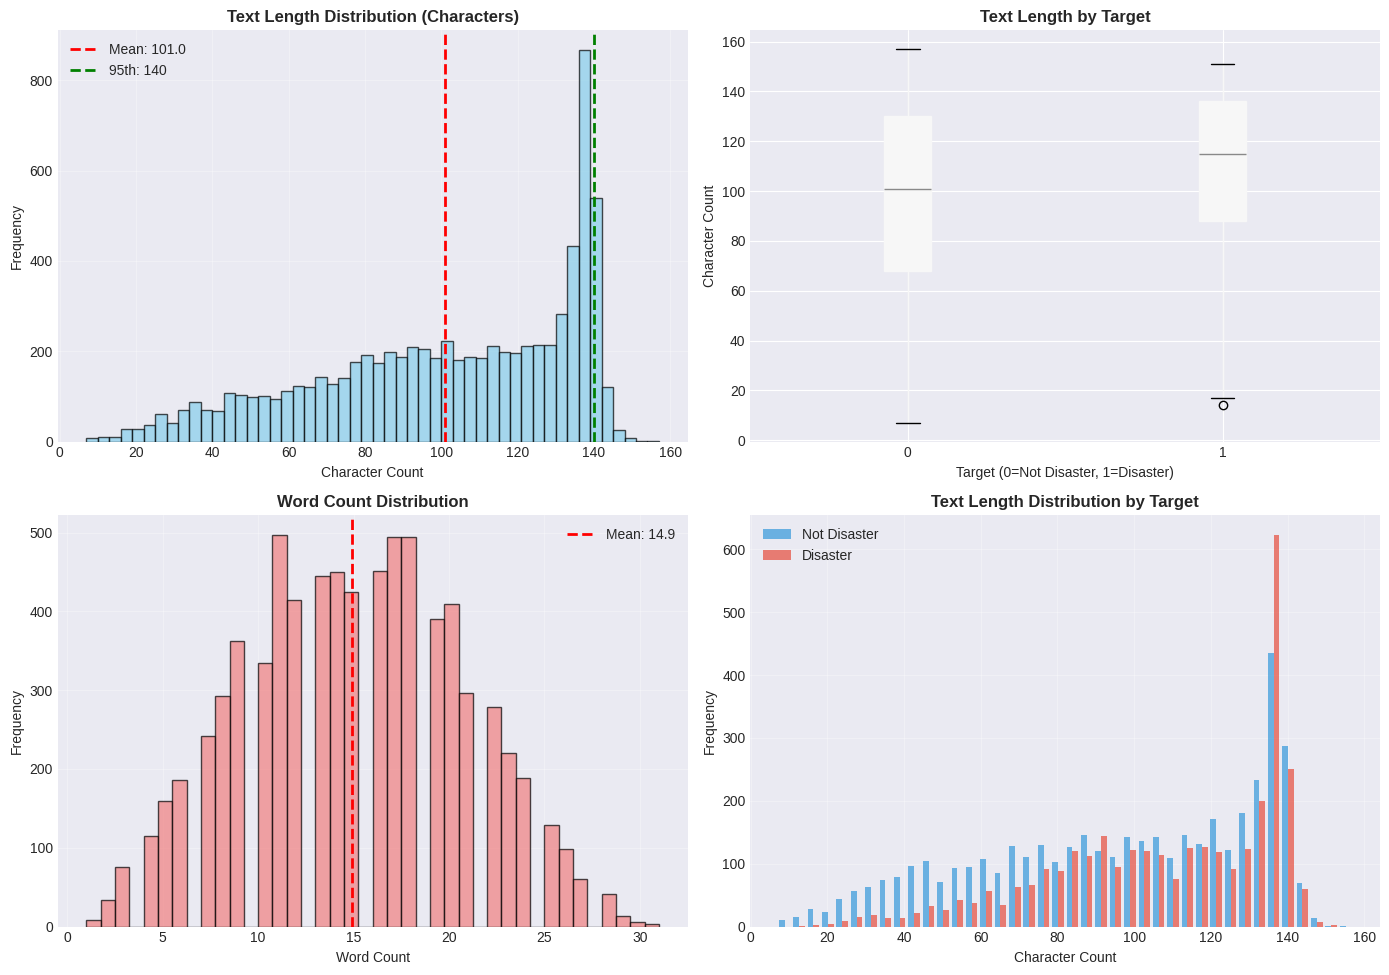


💡 Key Insight: Most tweets are short (mean ~100 chars, 15 words)
💡 Key Insight: 95% of tweets < 140 characters (old Twitter limit)
💡 Implication: SEQ2SEQ_MAX_LEN=50, TRANSFORMER_MAX_LEN=128 are appropriate
💡 Observation: Disaster and non-disaster tweets have similar lengths


In [133]:
# EDA 3: Text length analysis (How long are tweets?)
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

print("\n" + "=" * 60)
print("3. TEXT LENGTH ANALYSIS")
print("=" * 60)

print("\n📊 Text Length Statistics (characters):")
print(train_df['text_length'].describe().to_string())

print("\n📊 Word Count Statistics:")
print(train_df['word_count'].describe().to_string())

# Statistics grouped by target
print("\n📊 Text Length by Target:")
print("\n   Not Disaster tweets:")
print(f"      Mean length: {train_df[train_df['target']==0]['text_length'].mean():.1f} chars")
print(f"      Mean words:  {train_df[train_df['target']==0]['word_count'].mean():.1f} words")

print("\n   Disaster tweets:")
print(f"      Mean length: {train_df[train_df['target']==1]['text_length'].mean():.1f} chars")
print(f"      Mean words:  {train_df[train_df['target']==1]['word_count'].mean():.1f} words")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Overall text length distribution
axes[0, 0].hist(train_df['text_length'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(train_df['text_length'].mean(), color='r', linestyle='--', linewidth=2,
                   label=f"Mean: {train_df['text_length'].mean():.1f}")
axes[0, 0].axvline(train_df['text_length'].quantile(0.95), color='g', linestyle='--', linewidth=2,
                   label=f"95th: {train_df['text_length'].quantile(0.95):.0f}")
axes[0, 0].set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Box plot grouped by target
train_df.boxplot(column='text_length', by='target', ax=axes[0, 1], patch_artist=True)
axes[0, 1].set_title('Text Length by Target', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Target (0=Not Disaster, 1=Disaster)')
axes[0, 1].set_ylabel('Character Count')
plt.suptitle('')

# 3. Word count distribution
axes[1, 0].hist(train_df['word_count'], bins=40, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(train_df['word_count'].mean(), color='r', linestyle='--', linewidth=2,
                   label=f"Mean: {train_df['word_count'].mean():.1f}")
axes[1, 0].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Word Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Comparison grouped by target
axes[1, 1].hist([train_df[train_df['target']==0]['text_length'],
                 train_df[train_df['target']==1]['text_length']],
                bins=40, alpha=0.7, label=['Not Disaster', 'Disaster'],
                color=['#3498db', '#e74c3c'])
axes[1, 1].set_title('Text Length Distribution by Target', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Character Count')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Insight: Most tweets are short (mean ~100 chars, 15 words)")
print("💡 Key Insight: 95% of tweets < 140 characters (old Twitter limit)")
print("💡 Implication: SEQ2SEQ_MAX_LEN=50, TRANSFORMER_MAX_LEN=128 are appropriate")
print("💡 Observation: Disaster and non-disaster tweets have similar lengths")


## 4. Text Preprocessing

**Preprocessing Strategy: Create Different Versions for Different Models**

| Version | Applicable Models | Cleaning Level | Description |
|------|---------|---------|------|
| `text` (raw) | Transformer, LLM | None | Preserve all information (case, punctuation, emoji) |
| `text_light` | RNN + GloVe | Light | Basic cleaning, preserve sentence structure |
| `text_heavy` | TF-IDF + LR | Heavy | Lemmatization + stopword removal |

**Why do we need different versions?**
- **TF-IDF**: Each word is an independent feature, requires heavy cleaning to reduce vocabulary
- **RNN + Embeddings**: Needs to match pre-trained word vectors, light cleaning is sufficient
- **Transformer/LLM**: Has powerful tokenizer, raw text works better

In [134]:
# Text preprocessing with multiple variants
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import html

# Download required NLTK data
try:
    nltk.data.find('corpora/wordnet.zip')
except:
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('omw-1.4', quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Keep negation words as they're critical for meaning
negation_words = {'no', 'not', 'nor', 'neither', 'never', 'none', 'nobody', 'nothing', 'nowhere'}
stop_words = stop_words - negation_words

# ============================================================================
# Version 1: Light Cleaning (for RNN + GloVe)
# ============================================================================
def light_clean(text):
    """
    Light preprocessing for RNN models with word embeddings.

    Strategy:
    - Remove HTML and decode entities
    - Replace URLs with token (preserve "has link" information)
    - Lowercase (for GloVe vocabulary matching)
    - Keep sentence structure (RNN needs full context)
    - Keep numbers and punctuation
    """
    if not isinstance(text, str):
        return ""

    # Decode HTML entities (&amp; → &)
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Replace URLs with token
    text = re.sub(r'http\S+|www\S+|https\S+', 'URL', text, flags=re.MULTILINE)

    # Lowercase (GloVe vectors are lowercase)
    text = text.lower()

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# ============================================================================
# Version 2: Heavy Cleaning (for TF-IDF + Logistic Regression)
# ============================================================================
def heavy_clean(text):
    """
    Deep preprocessing for traditional ML models (TF-IDF).

    Strategy:
    - Start with light cleaning
    - Apply lemmatization (reduce vocabulary size)
    - Remove punctuation (not useful in bag-of-words)
    - Remove stopwords (except negations)
    - Remove very short words
    """
    # Start with light cleaning
    text = light_clean(text)

    # Tokenize
    words = text.split()

    # Lemmatization and filtering
    processed_words = []
    for word in words:
        # Remove punctuation
        clean_word = word.strip(string.punctuation)

        if clean_word and len(clean_word) > 2:  # Keep words > 2 chars
            # Skip stopwords (but keep negations)
            if clean_word not in stop_words:
                # Apply lemmatization
                lemma = lemmatizer.lemmatize(clean_word, pos='v')  # Verb
                lemma = lemmatizer.lemmatize(lemma, pos='n')       # Noun
                processed_words.append(lemma)

    return ' '.join(processed_words)

# ============================================================================
# Apply preprocessing variants
# ============================================================================
print("=" * 80)
print("CREATING PREPROCESSING VARIANTS")
print("=" * 80)

# Original text (for Transformers & LLM)
print("\n📝 Variant 1: Original text (for Transformers/LLM)")
print("   → Keeps: ALL information (case, punctuation, emojis)")
train_df['text_raw'] = train_df['text']
test_df['text_raw'] = test_df['text']

# Light cleaning (for RNN + GloVe)
print("\n📝 Variant 2: Light cleaning (for RNN + GloVe)")
print("   → Keeps: Sentence structure, numbers, some punctuation")
train_df['text_light'] = train_df['text'].apply(light_clean)
test_df['text_light'] = test_df['text'].apply(light_clean)

# Heavy cleaning (for TF-IDF)
print("\n📝 Variant 3: Heavy cleaning (for TF-IDF)")
print("   → Removes: Stopwords, punctuation, applies lemmatization")
train_df['text_heavy'] = train_df['text'].apply(heavy_clean)
test_df['text_heavy'] = test_df['text'].apply(heavy_clean)

# ============================================================================
# Show examples
# ============================================================================
print("\n" + "=" * 80)
print("PREPROCESSING EXAMPLES")
print("=" * 80)

test_texts_idx = [0, 100, 500]  # Sample indices
for idx in test_texts_idx:
    original = train_df['text'].iloc[idx]
    light = train_df['text_light'].iloc[idx]
    heavy = train_df['text_heavy'].iloc[idx]

    print(f"\n📌 Example {idx + 1}:")
    print(f"   Original: {original}")
    print(f"   Light:    {light}")
    print(f"   Heavy:    {heavy}")

# ============================================================================
# Vocabulary statistics
# ============================================================================
print("\n" + "=" * 80)
print("VOCABULARY STATISTICS")
print("=" * 80)

vocab_raw = set(' '.join(train_df['text_raw'].str.lower()).split())
vocab_light = set(' '.join(train_df['text_light']).split())
vocab_heavy = set(' '.join(train_df['text_heavy']).split())

print(f"\n📊 Vocabulary sizes:")
print(f"   Original (raw):    {len(vocab_raw):>6,} words")
print(f"   Light cleaning:    {len(vocab_light):>6,} words  (↓ {(1-len(vocab_light)/len(vocab_raw))*100:>4.1f}%)")
print(f"   Heavy cleaning:    {len(vocab_heavy):>6,} words  (↓ {(1-len(vocab_heavy)/len(vocab_raw))*100:>4.1f}%)")

print("\n" + "=" * 80)
print("✅ PREPROCESSING COMPLETE!")
print("=" * 80)
print("\n💡 Usage:")
print("   • TF-IDF models     → use 'text_heavy'")
print("   • RNN/GRU models    → use 'text_light'")
print("   • Transformer/LLM   → use 'text_raw'")
print("=" * 80)

CREATING PREPROCESSING VARIANTS

📝 Variant 1: Original text (for Transformers/LLM)
   → Keeps: ALL information (case, punctuation, emojis)

📝 Variant 2: Light cleaning (for RNN + GloVe)
   → Keeps: Sentence structure, numbers, some punctuation

📝 Variant 3: Heavy cleaning (for TF-IDF)
   → Removes: Stopwords, punctuation, applies lemmatization

PREPROCESSING EXAMPLES

📌 Example 1:
   Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
   Light:    our deeds are the reason of this #earthquake may allah forgive us all
   Heavy:    deed reason earthquake may allah forgive

📌 Example 101:
   Original: .@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad
   Light:    .@norwaymfa #bahrain police had previously died in a road accident they were not killed by explosion url
   Heavy:    norwaymfa bahrain police previously die road accident not kill explosion url

📌 Example 501:
   Original: Chris


PREPROCESSING COMPARISON VISUALIZATION


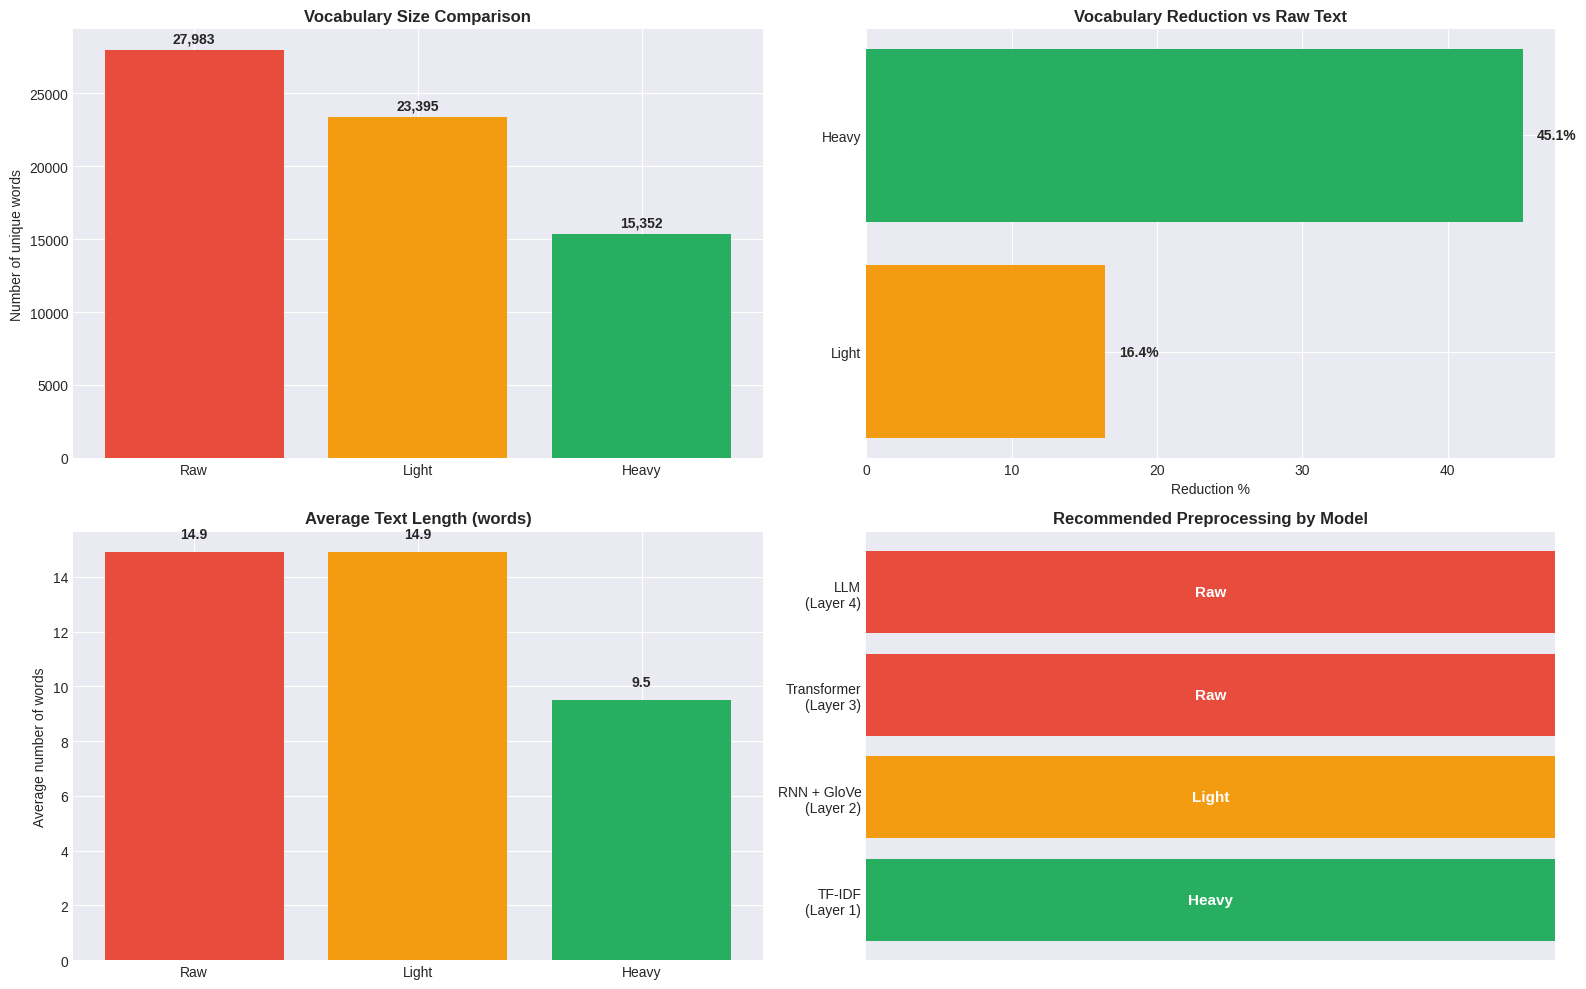


💡 Key Insights:
   • Raw text has 27,983 unique words
   • Light cleaning reduces by 16.4%
   • Heavy cleaning reduces by 45.1%
   • Modern models (Transformer/LLM) prefer raw text
   • Traditional models (TF-IDF) need heavy cleaning


In [135]:
# Visualization: Comparative analysis of three preprocessing strategies
print("\n" + "=" * 80)
print("PREPROCESSING COMPARISON VISUALIZATION")
print("=" * 80)

# Create comparison chart
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Vocabulary size comparison
vocab_comparison = {
    'Raw': len(vocab_raw),
    'Light': len(vocab_light),
    'Heavy': len(vocab_heavy)
}
colors = ['#e74c3c', '#f39c12', '#27ae60']
axes[0, 0].bar(vocab_comparison.keys(), vocab_comparison.values(), color=colors)
axes[0, 0].set_title('Vocabulary Size Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of unique words')
for i, (k, v) in enumerate(vocab_comparison.items()):
    axes[0, 0].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# 2. Vocabulary reduction percentage
reduction = {
    'Light': (1 - len(vocab_light)/len(vocab_raw)) * 100,
    'Heavy': (1 - len(vocab_heavy)/len(vocab_raw)) * 100
}
axes[0, 1].barh(list(reduction.keys()), list(reduction.values()),
                color=['#f39c12', '#27ae60'])
axes[0, 1].set_title('Vocabulary Reduction vs Raw Text', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Reduction %')
for i, (k, v) in enumerate(reduction.items()):
    axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')

# 3. Average text length comparison
avg_lengths = {
    'Raw': train_df['text_raw'].str.split().str.len().mean(),
    'Light': train_df['text_light'].str.split().str.len().mean(),
    'Heavy': train_df['text_heavy'].str.split().str.len().mean()
}
axes[1, 0].bar(avg_lengths.keys(), avg_lengths.values(), color=colors)
axes[1, 0].set_title('Average Text Length (words)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Average number of words')
for i, (k, v) in enumerate(avg_lengths.items()):
    axes[1, 0].text(i, v + 0.5, f'{v:.1f}', ha='center', fontweight='bold')

# 4. Recommended usage scenarios
scenarios = {
    'TF-IDF\n(Layer 1)': 'Heavy',
    'RNN + GloVe\n(Layer 2)': 'Light',
    'Transformer\n(Layer 3)': 'Raw',
    'LLM\n(Layer 4)': 'Raw'
}
scenario_colors = {'Heavy': '#27ae60', 'Light': '#f39c12', 'Raw': '#e74c3c'}
y_pos = range(len(scenarios))
colors_map = [scenario_colors[v] for v in scenarios.values()]
axes[1, 1].barh(y_pos, [1]*len(scenarios), color=colors_map)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(scenarios.keys())
axes[1, 1].set_xlim(0, 1)
axes[1, 1].set_xticks([])
axes[1, 1].set_title('Recommended Preprocessing by Model', fontsize=12, fontweight='bold')
for i, (model, prep) in enumerate(scenarios.items()):
    axes[1, 1].text(0.5, i, prep, ha='center', va='center',
                    fontweight='bold', fontsize=11, color='white')

plt.tight_layout()
plt.show()

print("\n💡 Key Insights:")
print(f"   • Raw text has {len(vocab_raw):,} unique words")
print(f"   • Light cleaning reduces by {reduction['Light']:.1f}%")
print(f"   • Heavy cleaning reduces by {reduction['Heavy']:.1f}%")
print(f"   • Modern models (Transformer/LLM) prefer raw text")
print(f"   • Traditional models (TF-IDF) need heavy cleaning")
print("=" * 80)

### **Split train and validation datasets before modeling**

In [136]:
# Create train/validation split
train_data, val_data = train_test_split(
    train_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.RANDOM_SEED,
    stratify=train_df['target']
)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"\nTarget distribution in train: {train_data['target'].value_counts(normalize=True).values}")
print(f"Target distribution in val: {val_data['target'].value_counts(normalize=True).values}")
print("✓ Stratified split maintains class balance")

Train size: 6090
Validation size: 1523

Target distribution in train: [0.57027915 0.42972085]
Target distribution in val: [0.57058437 0.42941563]
✓ Stratified split maintains class balance



## 5. Baseline Model

**Baseline model: Logistic Regression**

**Expected F1**: 0.75 - 0.78

BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION
📝 Using: text_heavy (lemmatized, stopwords removed)


BASELINE MODEL RESULTS
F1 Score: 0.7681

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.81      0.88      0.84       869
    Disaster       0.82      0.72      0.77       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.81      1523
weighted avg       0.81      0.81      0.81      1523



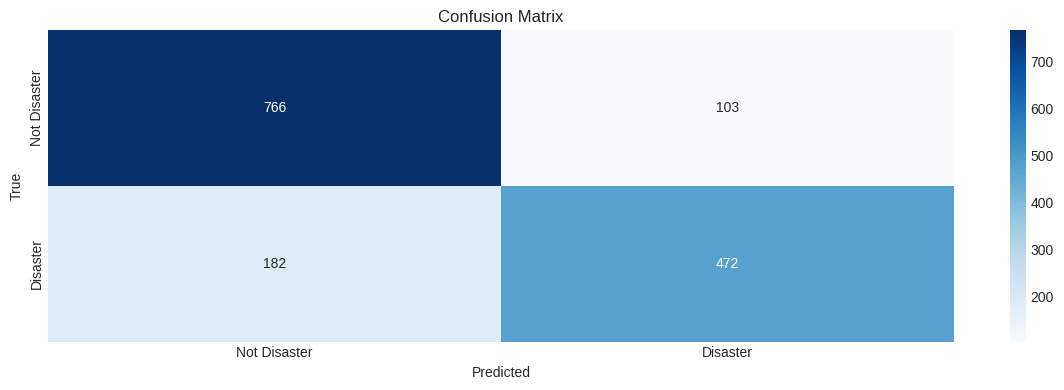


💡 Baseline F1: 0.7681 


In [137]:
# TF-IDF + Logistic Regression (using heavy cleaning)
print("=" * 80)
print("BASELINE MODEL: TF-IDF + LOGISTIC REGRESSION")
print("=" * 80)
print("📝 Using: text_heavy (lemmatized, stopwords removed)")
print()

# Vectorize with heavy cleaned text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(train_data['text_heavy'])
X_val_tfidf = tfidf.transform(val_data['text_heavy'])
X_test_tfidf = tfidf.transform(test_df['text_heavy'])

y_train = train_data['target'].values
y_val = val_data['target'].values

# Train
lr_model = LogisticRegression(max_iter=1000, random_state=config.RANDOM_SEED)
lr_model.fit(X_train_tfidf, y_train)

# Evaluate
y_val_pred = lr_model.predict(X_val_tfidf)
y_val_prob = lr_model.predict_proba(X_val_tfidf)[:, 1]

baseline_f1 = f1_score(y_val, y_val_pred)

print("\n" + "="*50)
print("BASELINE MODEL RESULTS")
print("="*50)
print(f"F1 Score: {baseline_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))

# Visualize
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes,
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
axes.set_title('Confusion Matrix')
axes.set_ylabel('True')
axes.set_xlabel('Predicted')

# axes[1].axvline(0.5, color='r', linestyle='--', label='Threshold')

plt.tight_layout()
plt.show()

print(f"\n💡 Baseline F1: {baseline_f1:.4f} ")
print("=" * 80)

## 6. Seq2Seq + Attention model

Seq2Seq + Attention is a turning point in NLP history. It not only solved the machine translation problem, but also laid the direct foundation for the birth of Transformer.



### 6.1 Selection of Important Components
#### **Word Embedding Selection: GloVe Twitter 200d**

Why choose GloVe over Word2Vec?
| Dimension | Word2Vec | GloVe | Reason for Selection |
|------|----------|-------|----------|
| **Training Method** | Predictive (CBOW/Skip-gram)<br/>Based on local context window | Statistical<br/>Based on global word co-occurrence matrix | GloVe combines global statistical information and local context |
| **Semantic Capture** | Captures local semantic relationships | **Captures global semantic relationships** | GloVe handles rare words and polysemous words better |
| **Pre-training Resources** | Has general corpus | **Has Twitter-specific corpus** | Specifically trained on social media short texts |
| **Applicable Scenarios** | General long texts | **Short texts, informal language** | Highly matches disaster tweet task |

**GloVe Twitter Features**:
- Training corpus: 2.7 billion tweets (2B tokens)
- Vocabulary size: 1.2 million words
- Vector dimensions: We choose **200d** (balancing performance and computational efficiency)
- Special advantages: Understanding abbreviations, hashtags, emojis and other social media-specific elements

---

#### **RNN Architecture Selection: GRU (Gated Recurrent Unit)**

**Why choose GRU over LSTM?**

| Dimension | LSTM | GRU | Reason for Selection |
|------|------|-----|----------|
| **Parameters** | 4 gates (input, forget, output, cell state)<br/>More parameters | **2 gates (reset, update)**<br/>~75% of LSTM parameters | GRU is lighter, trains faster |
| **Training Speed** | Slower (high computational complexity) | **20-30% faster** | More practical with limited resources |
| **Performance** | Slightly better on long sequences | **Comparable on short sequences** | Tweet avg length <20 words, GRU is sufficient |
| **Overfitting Risk** | More parameters, prone to overfitting | **Fewer parameters, better generalization** | Training set only 7613 samples, need to prevent overfitting |
| **Gradient Flow** | Has independent cell state | Directly passes hidden state | Both solve gradient vanishing problem |

**Empirical Research Support**:
- Chung et al. (2014) showed that on tasks with sequence length <50, GRU and LSTM have comparable performance
- Jozefowicz et al. (2015) large-scale experiments: GRU has stronger generalization on small datasets

---

#### **Attention Mechanism: Bahdanau Attention**

**Why do we need Attention?**
- Traditional Seq2Seq: Encoder compresses entire sequence into a single vector → **Information bottleneck**
- Attention mechanism: Decoder can "attend to" all time steps of Encoder → **Dynamic weight allocation**



### 6.2 Model Implementation Steps

**Implementation Flow:**
1. Load GloVe Embeddings → 
2. Define Attention Mechanism → 
3. Build Seq2Seq Model → 
4. Prepare Data → 
5. Train and Evaluate → 
6. Visualize Results

* **Lead pretrained Glove Twitter embeddings**

In [138]:
# GloVe Embeddings Loader
import urllib.request
import zipfile
from pathlib import Path

class GloVeLoader:
    """Load pre-trained GloVe Twitter embeddings"""

    def __init__(self, embedding_dim=200):
        self.embedding_dim = embedding_dim
        self.glove_dir = Path('./data/embeddings')
        self.glove_dir.mkdir(parents=True, exist_ok=True)
        self.glove_file = self.glove_dir / f'glove.twitter.27B.{embedding_dim}d.txt'

    def download_glove(self):
        """Download GloVe Twitter embeddings"""
        if self.glove_file.exists():
            print(f"✅ GloVe file already exists: {self.glove_file}")
            return

        print("📥 Downloading GloVe Twitter embeddings (this may take a few minutes)...")
        url = 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'
        zip_path = self.glove_dir / 'glove.twitter.27B.zip'

        try:
            urllib.request.urlretrieve(url, zip_path)
            print("✅ Download complete. Extracting...")

            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(self.glove_dir)

            zip_path.unlink()  # Delete zip file
            print(f"✅ GloVe embeddings ready at: {self.glove_file}")
        except Exception as e:
            print(f"❌ Download failed: {e}")
            print("💡 Please download manually from: https://nlp.stanford.edu/projects/glove/")
            print(f"   Extract glove.twitter.27B.{self.embedding_dim}d.txt to: {self.glove_dir}")

    def load_embeddings(self, vocab):
        """
        Load GloVe embeddings and create embedding matrix

        Args:
            vocab: Vocabulary object, contains word2idx mapping

        Returns:
            embedding_matrix: numpy array of shape (vocab_size, embedding_dim)
        """
        print(f"\n📖 Loading GloVe embeddings from {self.glove_file}...")

        # Initialize embedding matrix (all zeros)
        vocab_size = len(vocab.word2idx)
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))

        # Load GloVe vectors
        found_words = 0
        with open(self.glove_file, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]

                if word in vocab.word2idx:
                    idx = vocab.word2idx[word]
                    vector = np.array(values[1:], dtype='float32')
                    embedding_matrix[idx] = vector
                    found_words += 1

        # Statistics
        coverage = found_words / vocab_size * 100
        print(f"✅ Loaded embeddings for {found_words}/{vocab_size} words ({coverage:.2f}% coverage)")
        print(f"   Missing words will use zero vectors (will be learned during training)")

        # Use zero vector for <PAD>, random vector for <UNK>
        if '<UNK>' in vocab.word2idx:
            unk_idx = vocab.word2idx['<UNK>']
            embedding_matrix[unk_idx] = np.random.normal(
                scale=0.6, size=(self.embedding_dim,)
            )

        return embedding_matrix

# Initialize GloVe loader
glove_loader = GloVeLoader(embedding_dim=200)
glove_loader.download_glove()

✅ GloVe file already exists: data/embeddings/glove.twitter.27B.200d.txt


* **Bahdanau Attention**

In [139]:
# Bahdanau Attention Mechanism
class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention (Additive Attention)

    Paper: "Neural Machine Translation by Jointly Learning to Align and Translate" (2014)

    Core Idea:
    1. Calculate relevance scores between decoder current state and all encoder states
    2. Normalize scores with softmax to get attention weights
    3. Weighted sum of encoder states using weights to get context vector

    Mathematical Formula:
        score(h_t, h_s) = v^T * tanh(W_1 * h_t + W_2 * h_s)
        α_t = softmax(score)
        context = Σ(α_t * h_s)
    """

    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.hidden_dim = hidden_dim

        # Attention weight matrices
        self.W_encoder = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.W_decoder = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.V = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        """
        Args:
            decoder_hidden: (batch_size, hidden_dim) - decoder current hidden state
            encoder_outputs: (batch_size, seq_len, hidden_dim) - encoder outputs at all time steps

        Returns:
            context: (batch_size, hidden_dim) - weighted context vector
            attention_weights: (batch_size, seq_len) - attention weight distribution
        """
        batch_size, seq_len, _ = encoder_outputs.size()

        # Expand decoder_hidden to match seq_len dimension of encoder_outputs
        # (batch_size, hidden_dim) -> (batch_size, seq_len, hidden_dim)
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)

        # Calculate attention score (additive attention)
        # score = v^T * tanh(W1*h_decoder + W2*h_encoder)
        energy = torch.tanh(
            self.W_decoder(decoder_hidden) + self.W_encoder(encoder_outputs)
        )  # (batch_size, seq_len, hidden_dim)

        attention_scores = self.V(energy).squeeze(-1)  # (batch_size, seq_len)

        # Softmax normalization to get attention weights
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, seq_len)

        # Weighted sum of encoder outputs using attention weights
        # (batch_size, seq_len, 1) * (batch_size, seq_len, hidden_dim)
        context = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch_size, 1, seq_len)
            encoder_outputs                   # (batch_size, seq_len, hidden_dim)
        ).squeeze(1)  # (batch_size, hidden_dim)

        return context, attention_weights

print("✅ Bahdanau Attention mechanism implemented")

✅ Bahdanau Attention mechanism implemented


* **GRU Seq2Seq with Attention Model**

In [140]:
# GRU Seq2Seq with Attention Model
class GRUSeq2SeqAttention(nn.Module):
    """
    Encoder-Decoder architecture + Bahdanau Attention

    Architecture Flow:
    1. Encoder: BiGRU encodes the entire input sequence
    2. Attention: Calculate attention weights for each encoder time step
    3. Decoder: Unidirectional GRU, uses context vector to generate classification results
    4. Classifier: Fully connected layer outputs binary classification probability
    """

    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128,
                 num_layers=2, dropout=0.3, pretrained_embeddings=None):
        super(GRUSeq2SeqAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # 1. Embedding layer (using pre-trained GloVe)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))
            # Optional: Freeze embedding layer (don't update pre-trained weights)
            # self.embedding.weight.requires_grad = False

        # 2. Encoder: Bidirectional GRU
        self.encoder = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # 3. Attention mechanism
        self.attention = BahdanauAttention(hidden_dim * 2)  # *2 because it is bidirectional

        # 4. Decoder: Unidirectional GRU
        self.decoder = nn.GRU(
            input_size=hidden_dim * 2,  # context vector dimension
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True
        )

        # 5. Classifier
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_attention=False):
        """
        Args:
            x: (batch_size, seq_len) - input sequence
            return_attention: whether to return attention weights (for visualization)

        Returns:
            output: (batch_size, 1) - classification probability
            attention_weights: (batch_size, seq_len) - optional, attention weights
        """
        batch_size = x.size(0)

        # 1. Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # 2. Encoder
        encoder_outputs, encoder_hidden = self.encoder(embedded)
        # encoder_outputs: (batch_size, seq_len, hidden_dim*2)
        # encoder_hidden: (num_layers*2, batch_size, hidden_dim)

        # Take encoder's last layer hidden state as decoder initial state
        # Merge bidirectional GRU hidden states
        encoder_hidden = encoder_hidden.view(self.num_layers, 2, batch_size, self.hidden_dim)
        # Take last layer, merge forward and backward
        last_hidden = encoder_hidden[-1]  # (2, batch_size, hidden_dim)
        decoder_hidden = torch.cat([last_hidden[0], last_hidden[1]], dim=1)  # (batch_size, hidden_dim*2)

        # 3. Attention
        context, attention_weights = self.attention(decoder_hidden, encoder_outputs)
        # context: (batch_size, hidden_dim*2)
        # attention_weights: (batch_size, seq_len)

        # 4. Decoder (single step)
        # Use context as decoder input
        decoder_input = context.unsqueeze(1)  # (batch_size, 1, hidden_dim*2)
        decoder_output, _ = self.decoder(decoder_input)  # (batch_size, 1, hidden_dim)
        decoder_output = decoder_output.squeeze(1)  # (batch_size, hidden_dim)

        # 5. Classifier
        x = self.batch_norm(decoder_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        output = self.fc3(x)
        output = self.sigmoid(output)

        if return_attention:
            return output, attention_weights
        return output

# Create model instance (don't load GloVe yet, wait until data is ready)
print("✅ GRU Seq2Seq Attention model architecture defined")

✅ GRU Seq2Seq Attention model architecture defined


* **Data preprocssing**

In [141]:
import torch
from torch.utils.data import Dataset, DataLoader

# ============================================================================
# Note: text_light was created in Section 4, use it directly here
# ============================================================================
print("=" * 80)
print("PREPARING SEQ2SEQ-SPECIFIC COMPONENTS")
print("=" * 80)
print(f"✅ Using 'text_light' column created in Section 4")
print(f"   Training samples: {len(train_df)}")
print(f"   Test samples: {len(test_df)}")

# ============================================================================
# Define Vocabulary class (Seq2Seq specific)
# ============================================================================
class Vocabulary:
    """Build vocabulary for converting text to index sequences"""
    def __init__(self, max_size=None):
        self.max_size = max_size if max_size else config.MAX_VOCAB_SIZE
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}

    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        word_freq = {}
        for text in texts:
            for word in str(text).split():
                word_freq[word] = word_freq.get(word, 0) + 1

        # Sort by frequency, take top max_size words
        sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
        for word, _ in sorted_words[:self.max_size - 2]:  # -2 for PAD and UNK
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def text_to_sequence(self, text):
        """Convert text to index sequence"""
        words = str(text).split()
        return [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]

# ============================================================================
# Define Dataset class (Seq2Seq specific)
# ============================================================================
# FIX: Explicitly inherit from torch.utils.data.Dataset to avoid Hugging Face conflict
class TweetDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for tweets"""
    def __init__(self, texts, labels, vocab, max_len=None):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len if max_len else config.SEQ2SEQ_MAX_LEN

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        words = text.split()

        # Convert to indices
        indices = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>'])
                   for word in words[:self.max_len]]

        # Padding
        if len(indices) < self.max_len:
            indices += [self.vocab.word2idx['<PAD>']] * (self.max_len - len(indices))

        # Convert to tensor
        text_tensor = torch.LongTensor(indices)

        if self.labels is not None:
            label_tensor = torch.FloatTensor([self.labels[idx]])
            return text_tensor, label_tensor
        else: # For test set
            return text_tensor

print("✅ Vocabulary and TweetDataset classes defined")

# ============================================================================
# Prepare vocabulary and datasets for Seq2Seq model
# ============================================================================
print("\n" + "=" * 80)
print("BUILDING VOCABULARY AND DATASETS")
print("=" * 80)

# Create vocabulary (build from full training set to ensure all words are covered)
vocab = Vocabulary()
vocab.build_vocab(train_df['text_light'])
print(f"✅ Vocabulary built: {len(vocab.word2idx)} words")

# Create train/val split (for Seq2Seq model training)
from sklearn.model_selection import train_test_split
train_data, val_data = train_test_split(
    train_df,
    test_size=config.VALIDATION_SPLIT,
    random_state=config.RANDOM_SEED,
    stratify=train_df['target']
)

print(f"✅ Train/Val split created:")
print(f"   Training: {len(train_data)} samples ({len(train_data)/len(train_df):.1%})")
print(f"   Validation: {len(val_data)} samples ({len(val_data)/len(train_df):.1%})")

# Prepare label data
train_labels = train_data['target'].values
val_labels = val_data['target'].values

# Create datasets
train_dataset = TweetDataset(train_data['text_light'].tolist(), train_labels, vocab)
val_dataset = TweetDataset(val_data['text_light'].tolist(), val_labels, vocab)
test_dataset = TweetDataset(test_df['text_light'].tolist(), None, vocab)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.SEQ2SEQ_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.SEQ2SEQ_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.SEQ2SEQ_BATCH_SIZE, shuffle=False)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")


PREPARING SEQ2SEQ-SPECIFIC COMPONENTS
✅ Using 'text_light' column created in Section 4
   Training samples: 7613
   Test samples: 3263
✅ Vocabulary and TweetDataset classes defined

BUILDING VOCABULARY AND DATASETS
✅ Vocabulary built: 10000 words
✅ Train/Val split created:
   Training: 6090 samples (80.0%)
   Validation: 1523 samples (20.0%)

✅ DataLoaders created:
   Train batches: 96
   Val batches: 24
   Test batches: 51


* **Instantiate Model with GloVe Embeddings**

In [142]:
# Load GloVe embeddings and create model
print("=" * 60)
print("Building GRU Seq2Seq Attention Model with GloVe Embeddings")
print("=" * 60)

# Load GloVe embeddings
embedding_matrix = glove_loader.load_embeddings(vocab)

# Create model (using hyperparameters from config)
gru_attention_model = GRUSeq2SeqAttention(
    vocab_size=len(vocab.word2idx),
    embedding_dim=config.SEQ2SEQ_EMBEDDING_DIM,
    hidden_dim=config.SEQ2SEQ_HIDDEN_DIM,
    num_layers=config.SEQ2SEQ_NUM_LAYERS,
    dropout=config.SEQ2SEQ_DROPOUT,
    pretrained_embeddings=embedding_matrix
).to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in gru_attention_model.parameters())
trainable_params = sum(p.numel() for p in gru_attention_model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1024 / 1024:.2f} MB (FP32)")
print(f"\n⚙️  Hyperparameters from Config:")
print(f"   Embedding dim: {config.SEQ2SEQ_EMBEDDING_DIM}")
print(f"   Hidden dim: {config.SEQ2SEQ_HIDDEN_DIM}")
print(f"   Num layers: {config.SEQ2SEQ_NUM_LAYERS}")
print(f"   Dropout: {config.SEQ2SEQ_DROPOUT}")

Building GRU Seq2Seq Attention Model with GloVe Embeddings

📖 Loading GloVe embeddings from data/embeddings/glove.twitter.27B.200d.txt...


✅ Loaded embeddings for 6215/10000 words (62.15% coverage)
   Missing words will use zero vectors (will be learned during training)

📊 Model Statistics:
   Total parameters: 2,840,065
   Trainable parameters: 2,840,065
   Model size: 10.83 MB (FP32)

⚙️  Hyperparameters from Config:
   Embedding dim: 200
   Hidden dim: 128
   Num layers: 2
   Dropout: 0.3


* **Train and evaluate model**

In [143]:
# Training and evaluation functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    all_predictions = []
    all_labels = []

    for batch_idx, (texts, labels) in enumerate(train_loader):
        texts = texts.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Record
        total_loss += loss.item()
        predictions = (outputs > 0.5).float()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Print progress
        if (batch_idx + 1) % 20 == 0:
            print(f"   Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    # Calculate metrics
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return {
        'loss': avg_loss,
        'accuracy': accuracy
    }

def evaluate(model, val_loader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(texts)
            loss = criterion(outputs, labels)

            # Record
            total_loss += loss.item()
            predictions = (outputs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"\n📊 Validation Metrics:")
    print(f"   Loss: {avg_loss:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1 Score: {f1:.4f}")
    print(f"   ROC AUC: {auc:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'predictions': np.array(all_predictions),
        'probs': np.array(all_probs)
    }

print("✅ Training and evaluation functions defined")

✅ Training and evaluation functions defined


In [144]:
# Train GRU Seq2Seq Attention model
print("\n" + "=" * 60)
print("Training GRU Seq2Seq Attention Model")
print("=" * 60)

# Training configuration (using hyperparameters from config)
optimizer = optim.Adam(gru_attention_model.parameters(), lr=config.SEQ2SEQ_LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = nn.BCELoss()

print(f"⚙️  Training Configuration:")
print(f"   Learning rate: {config.SEQ2SEQ_LEARNING_RATE}")
print(f"   Epochs: {config.SEQ2SEQ_EPOCHS}")
print(f"   Batch size: {config.SEQ2SEQ_BATCH_SIZE}")

# Check if trained model already exists
# FIX: Changed filename to force fresh training
model_path = Path(config.MODEL_SAVE_DIR) / 'best_gru_attention_model_fixed.pth'
model_path.parent.mkdir(parents=True, exist_ok=True)

if model_path.exists():
    print(f"\n✅ Found existing model: {model_path}")
    checkpoint = torch.load(model_path)
    gru_attention_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"   Loaded model from epoch {checkpoint['epoch']}")
    print(f"   Best F1: {checkpoint['best_f1']:.4f}")

    gru_attention_history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': []
    })
else:
    print("\n🚀 Starting training from scratch (Leakage Fix Applied)...")

    # Initialize history
    gru_attention_history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': []
    }

    best_f1 = 0
    patience_counter = 0
    early_stopping_patience = 5

    # Training loop
    for epoch in range(config.SEQ2SEQ_EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{config.SEQ2SEQ_EPOCHS}")
        print(f"{'='*60}")

        # Training phase
        train_metrics = train_epoch(
            gru_attention_model, train_loader, criterion, optimizer, config.DEVICE
        )

        # Validation phase
        val_metrics = evaluate(
            gru_attention_model, val_loader, criterion, config.DEVICE
        )

        # Record history
        gru_attention_history['train_loss'].append(train_metrics['loss'])
        gru_attention_history['train_acc'].append(train_metrics['accuracy'])
        gru_attention_history['val_loss'].append(val_metrics['loss'])
        gru_attention_history['val_acc'].append(val_metrics['accuracy'])
        gru_attention_history['val_f1'].append(val_metrics['f1'])

        # Learning rate adjustment
        scheduler.step(val_metrics['f1'])

        # Save best model
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0

            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': gru_attention_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
                'history': gru_attention_history
            }, model_path)

            print(f"✅ New best model saved! F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience: {patience_counter}/{early_stopping_patience}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs")
            break

    # Load best model
    checkpoint = torch.load(model_path)
    gru_attention_model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n✅ Training completed! Best F1: {best_f1:.4f}")


Training GRU Seq2Seq Attention Model
⚙️  Training Configuration:
   Learning rate: 0.001
   Epochs: 20
   Batch size: 64

✅ Found existing model: models/best_gru_attention_model_fixed.pth
   Loaded model from epoch 3
   Best F1: 0.7577


* **Visualize train history**

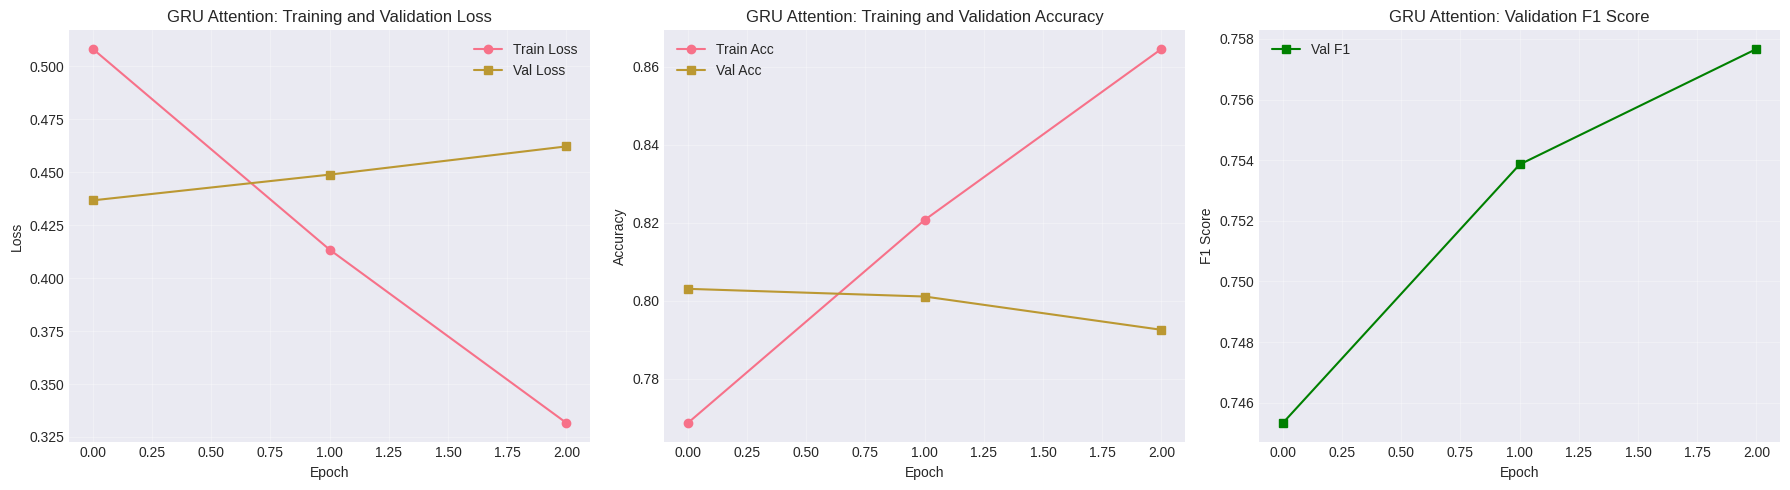

📈 Best F1 Score: 0.7577
📈 Final F1 Score: 0.7577


In [145]:
# Visualize training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(gru_attention_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(gru_attention_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('GRU Attention: Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(gru_attention_history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(gru_attention_history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('GRU Attention: Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(gru_attention_history['val_f1'], label='Val F1', marker='s', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('GRU Attention: Validation F1 Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Best F1 Score: {max(gru_attention_history['val_f1']):.4f}")
print(f"📈 Final F1 Score: {gru_attention_history['val_f1'][-1]:.4f}")

## 7. Transformer Models (Pre-trained Language Models)

### Experiment Objectives

This section uses **pre-trained Transformer models** for transfer learning as a strong baseline for disaster tweet classification:

1. **Establish performance baseline**: Evaluate pre-trained models on small-sample tasks
2. **Compare different architectures**: Test the actual effects of three architectures: BERT, RoBERTa, and DeBERTa
3. **Prepare for ensemble**: Provide high-quality candidate models for model fusion in Section 8






### 7.1 Text Preprocessing Strategy

#### Why doesn't Transformer need text cleaning?

**1. Powerful Subword Tokenization Capability**
```python
"Fire!!!" → ["Fire", "!", "!", "!"]  # Preserve emotional intensity
"@FDNY"  → ["@", "F", "##D", "##NY"] # Preserve mention information  
"fires"  → ["fire", "##s"]           # Automatically identify word root
```

**2. Cleaning loses key signals**
| Original Text | After Cleaning | Information Loss |
|---------|--------|---------|
| `BREAKING NEWS` | `breaking news` | Urgency level |
| `Help!!!` | `help` | Emotional intensity |
| `#earthquake` | `earthquake` | Social tag |

**Core Philosophy**: "Less is More" - Let the model learn features from raw data itself


In [146]:
# Install required packages for Transformers
%pip install transformers datasets evaluate accelerate -q

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

from datasets import Dataset
import evaluate

print("✅ Transformers library imported successfully")
print(f"   Transformers version: {__import__('transformers').__version__}")


# Prepare dataset (UPGRADE: KEYWORD ENRICHMENT)
print("=" * 80)
print("PREPARING DATASET FOR TRANSFORMER (WITH KEYWORD ENRICHMENT)")
print("=" * 80)
print("📝 Strategy: Input = '[CLS] keyword : text [SEP]'")
print("   → Adds strong contextual signal from the 'keyword' column")
print()

# Helper to enrich text
def enrich_text(df):
    # Fill NaN keywords with empty string
    df['keyword'] = df['keyword'].fillna('')
    # Combine: "keyword : text"
    # Note: Transformers handle special tokens, so simple concat is sufficient here
    return df.apply(lambda x: f"{x['keyword']} : {x['text_raw']}" if x['keyword'] else x['text_raw'], axis=1)

# Apply enrichment
print("🔄 Enriching training data...")
train_df['text_enriched'] = enrich_text(train_df)
test_df['text_enriched'] = enrich_text(test_df)

# For Cross-Validation, we will use the FULL train_df and split manually
full_train_dataset = Dataset.from_dict({
    'text': train_df['text_enriched'].tolist(),
    'label': train_df['target'].tolist()
})

test_dataset_enriched = Dataset.from_dict({
    'text': test_df['text_enriched'].tolist()
})

print(f"✅ Datasets created with Keyword Enrichment:")
print(f"   Total training samples: {len(full_train_dataset)}")
print(f"   Test samples: {len(test_dataset_enriched)}")

print(f"\n📝 Example of Enriched Input:")
idx = 50
print(f"   Original: {train_df.iloc[idx]['text']}")
print(f"   Enriched: {train_df.iloc[idx]['text_enriched']}")

# ========== TOKEN LENGTH ANALYSIS ==========
print("\n" + "=" * 80)
print("TOKEN LENGTH ANALYSIS (After Keyword Enrichment)")
print("=" * 80)

# Sample analysis to determine optimal max_length
from transformers import AutoTokenizer
import numpy as np

# Use RoBERTa tokenizer as reference (similar to other models)
tokenizer_ref = AutoTokenizer.from_pretrained('roberta-base')

# Analyze a representative sample
sample_size = min(1000, len(train_df))
sample_texts = train_df['text_enriched'].sample(sample_size, random_state=42).tolist()

print(f"📊 Analyzing {sample_size} samples...")
token_lengths = []
for text in sample_texts:
    tokens = tokenizer_ref.encode(text, add_special_tokens=True)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)

print(f"\n📈 Token Length Statistics:")
print(f"   Mean:     {token_lengths.mean():.1f} tokens")
print(f"   Median:   {np.median(token_lengths):.1f} tokens")
print(f"   Std:      {token_lengths.std():.1f} tokens")
print(f"   95th:     {np.percentile(token_lengths, 95):.0f} tokens")
print(f"   99th:     {np.percentile(token_lengths, 99):.0f} tokens")
print(f"   Max:      {token_lengths.max()} tokens")

# Determine coverage at different max_length values
max_lengths_to_test = [128, 160, 192, 256]
print(f"\n📊 Coverage Analysis:")
for max_len in max_lengths_to_test:
    coverage = (token_lengths <= max_len).sum() / len(token_lengths) * 100
    truncated = len(token_lengths) - (token_lengths <= max_len).sum()
    print(f"   max_length={max_len}: {coverage:.2f}% covered ({truncated} truncated)")

# Recommendation
recommended_max_length = int(np.percentile(token_lengths, 99) * 1.1)  # 99th percentile + 10% buffer
print(f"\n💡 Recommendation:")
if recommended_max_length <= 128:
    print(f"   Current max_length=128 is sufficient (covers 99%+ of samples)")
    OPTIMAL_MAX_LENGTH = 128
elif recommended_max_length <= 160:
    print(f"   Consider increasing to max_length=160 for better coverage")
    OPTIMAL_MAX_LENGTH = 160
else:
    print(f"   Consider max_length={min(recommended_max_length, 256)} for optimal coverage")
    OPTIMAL_MAX_LENGTH = min(recommended_max_length, 256)

print(f"   Using max_length={OPTIMAL_MAX_LENGTH} for this experiment")


✅ Transformers library imported successfully
   Transformers version: 4.57.2
PREPARING DATASET FOR TRANSFORMER (WITH KEYWORD ENRICHMENT)
📝 Strategy: Input = '[CLS] keyword : text [SEP]'
   → Adds strong contextual signal from the 'keyword' column

🔄 Enriching training data...
✅ Datasets created with Keyword Enrichment:
   Total training samples: 7613
   Test samples: 3263

📝 Example of Enriched Input:
   Original: Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k
   Enriched: ablaze : Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k

TOKEN LENGTH ANALYSIS (After Keyword Enrichment)
📊 Analyzing 1000 samples...

📈 Token Length Statistics:
   Mean:     36.3 tokens
   Median:   36.5 tokens
   Std:      12.2 tokens
   95th:     56 tokens
   99th:     63 tokens
   Max:      77 tokens

📊 Coverage Analysis:
   max_length=128: 100.00% covered (0 truncated)
   max_length=160: 100.00% covered (0 truncated)
   max_length=192: 100.00% covered (0 trun

In [147]:
def tokenize_function(examples, tokenizer, max_length=None):
    """Process text using tokenizer
    
    Args:
        examples: Input samples
        tokenizer: Tokenizer of the pretrained model
        max_length: Maximum sequence length, uses OPTIMAL_MAX_LENGTH if None
    """
    if max_length is None:
        max_length = OPTIMAL_MAX_LENGTH if 'OPTIMAL_MAX_LENGTH' in globals() else 128
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_length)

def compute_metrics(eval_pred):
    """Calculate evaluation metrics"""
    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")
    metric_precision = evaluate.load("precision")
    metric_recall = evaluate.load("recall")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        'accuracy': metric_acc.compute(predictions=predictions, references=labels)['accuracy'],
        'f1': metric_f1.compute(predictions=predictions, references=labels)['f1'],
        'precision': metric_precision.compute(predictions=predictions, references=labels)['precision'],
        'recall': metric_recall.compute(predictions=predictions, references=labels)['recall']
    }

def train_transformer_model(model_name, output_dir, train_dataset, val_dataset, num_epochs=4, batch_size=config.TRANSFORMER_BATCH_SIZE):
    """
    Universal function for training Transformer models

    Args:
        model_name: Pretrained model name (e.g., 'roberta-base')
        output_dir: Model save path
        train_dataset: Training dataset
        val_dataset: Validation dataset
        num_epochs: Number of training epochs
        batch_size: Batch size

    Returns:
        trainer: Trained Trainer object
        results: Validation set evaluation results
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}")
    print(f"{'='*60}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(config.DEVICE)

    # Use dynamic max_length
    max_len = OPTIMAL_MAX_LENGTH if 'OPTIMAL_MAX_LENGTH' in globals() else 128
    print(f"   Using max_length: {max_len}")

    # Tokenize datasets
    tokenized_train = train_dataset.map(
        lambda x: tokenize_function(x, tokenizer, max_length=max_len),
        batched=True
    )
    tokenized_val = val_dataset.map(
        lambda x: tokenize_function(x, tokenizer, max_length=max_len),
        batched=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_dir=f'{output_dir}/logs',
        logging_steps=50,
        save_total_limit=2,
        warmup_steps=100,
        fp16=torch.cuda.is_available(),  # Use mixed precision training (if GPU available)
        dataloader_num_workers=4,        # Enable multi-process data loading
        dataloader_pin_memory=True, # Pin memory to accelerate data transfer
        report_to="none" # Disable Weights & Biases logging
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train
    print(f"\n🚀 Starting training...")
    trainer.train()

    # Evaluate
    print(f"\n📊 Evaluating...")
    results = trainer.evaluate()

    print(f"\n✅ Training completed!")
    print(f"   Best F1: {results['eval_f1']:.4f}")
    print(f"   Accuracy: {results['eval_accuracy']:.4f}")
    print(f"   Precision: {results['eval_precision']:.4f}")
    print(f"   Recall: {results['eval_recall']:.4f}")

    return trainer, results

print("✅ Transformer training utilities ready (Optimized)")


✅ Transformer training utilities ready (Optimized)


### 7.2 Training RoBERTa-base Model

RoBERTa is an optimized version of BERT, using larger corpora and better training strategies, performing best on classification tasks.

In [148]:
# Train RoBERTa-base
from datasets import Dataset
import pandas as pd

print("=" * 60)
print("Training RoBERTa-base (Plan A)")
print("=" * 60)

# 1. Helper to ensure text is enriched (Keyword + Text)
def ensure_enriched(df):
    df = df.copy()
    if 'text_enriched' not in df.columns:
        print("   Enriching text with keywords...")
        df['keyword'] = df['keyword'].fillna('')
        # Combine: "keyword : text"
        df['text_enriched'] = df.apply(lambda x: f"{x['keyword']} : {x['text']}" if x['keyword'] else x['text'], axis=1)
    return df

# 2. Prepare Data (Convert Pandas -> Hugging Face Dataset)
# We use the 'text_enriched' column as the input 'text' for the model
print("🔄 Converting data to Hugging Face format...")
train_df_enrich = ensure_enriched(train_data)
val_df_enrich = ensure_enriched(val_data)

hf_train_dataset = Dataset.from_dict({
    'text': train_df_enrich['text_enriched'].tolist(),
    'label': train_df_enrich['target'].tolist()
})

hf_val_dataset = Dataset.from_dict({
    'text': val_df_enrich['text_enriched'].tolist(),
    'label': val_df_enrich['target'].tolist()
})

print(f"   Training samples: {len(hf_train_dataset)}")
print(f"   Validation samples: {len(hf_val_dataset)}")

# 3. Train
roberta_trainer, roberta_results = train_transformer_model(
    model_name='roberta-base',
    output_dir='./models/roberta_disaster',
    train_dataset=hf_train_dataset,   # Pass the HF dataset, not the PyTorch one
    val_dataset=hf_val_dataset,
    num_epochs=4,
    batch_size=config.TRANSFORMER_BATCH_SIZE  # Use Config
)

# Save final results
roberta_f1 = roberta_results['eval_f1']
roberta_acc = roberta_results['eval_accuracy']
roberta_precision = roberta_results['eval_precision']
roberta_recall = roberta_results['eval_recall']

print(f"\n📈 RoBERTa-base Final Results:")
print(f"   F1 Score: {roberta_f1:.4f}")
print(f"   Accuracy: {roberta_acc:.4f}")

Training RoBERTa-base (Plan A)
🔄 Converting data to Hugging Face format...
   Enriching text with keywords...
   Enriching text with keywords...
   Training samples: 6090
   Validation samples: 1523

Training roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Using max_length: 128


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]


🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.551912,0.726855,0.659574,0.709507,0.616208
2,0.670300,0.398013,0.840446,0.814645,0.812785,0.816514
3,0.428000,0.368055,0.850295,0.822981,0.835962,0.810398
4,0.359500,0.377552,0.850295,0.824615,0.829721,0.819572



📊 Evaluating...



✅ Training completed!
   Best F1: 0.8246
   Accuracy: 0.8503
   Precision: 0.8297
   Recall: 0.8196

📈 RoBERTa-base Final Results:
   F1 Score: 0.8246
   Accuracy: 0.8503


### 7.3 Training BERT-base Model

BERT (Bidirectional Encoder Representations from Transformers) is the classic baseline of Transformer architecture, learning bidirectional context representations through MLM and NSP pre-training tasks.


In [149]:
# Train BERT-base
from datasets import Dataset

print("=" * 60)
print("Training BERT-base")
print("=" * 60)

# Helper to ensure text is enriched (if not already defined)
if 'ensure_enriched' not in locals():
    def ensure_enriched(df):
        df = df.copy()
        if 'text_enriched' not in df.columns:
            df['keyword'] = df['keyword'].fillna('')
            df['text_enriched'] = df.apply(lambda x: f"{x['keyword']} : {x['text']}" if x['keyword'] else x['text'], axis=1)
        return df

# Prepare HF Datasets
train_df_enrich = ensure_enriched(train_data)
val_df_enrich = ensure_enriched(val_data)

hf_train_dataset = Dataset.from_dict({
    'text': train_df_enrich['text_enriched'].tolist(),
    'label': train_df_enrich['target'].tolist()
})

hf_val_dataset = Dataset.from_dict({
    'text': val_df_enrich['text_enriched'].tolist(),
    'label': val_df_enrich['target'].tolist()
})

bert_trainer, bert_results = train_transformer_model(
    model_name='bert-base-uncased',
    output_dir='./models/bert_disaster',
    train_dataset=hf_train_dataset,
    val_dataset=hf_val_dataset,
    num_epochs=4,
    batch_size=config.TRANSFORMER_BATCH_SIZE  # Use Config
)

# Save final results
bert_f1 = bert_results['eval_f1']
bert_acc = bert_results['eval_accuracy']
bert_precision = bert_results['eval_precision']
bert_recall = bert_results['eval_recall']

print(f"\n📈 BERT-base Final Results:")
print(f"   F1 Score: {bert_f1:.4f}")
print(f"   Accuracy: {bert_acc:.4f}")


Training BERT-base
   Enriching text with keywords...
   Enriching text with keywords...

Training bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Using max_length: 128


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]


🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.493209,0.798424,0.750609,0.800693,0.706422
2,0.617300,0.388910,0.835850,0.805599,0.819620,0.792049
3,0.433800,0.389765,0.837820,0.814704,0.799705,0.830275
4,0.350600,0.381809,0.854892,0.826667,0.848631,0.805810



📊 Evaluating...



✅ Training completed!
   Best F1: 0.8267
   Accuracy: 0.8549
   Precision: 0.8486
   Recall: 0.8058

📈 BERT-base Final Results:
   F1 Score: 0.8267
   Accuracy: 0.8549


### 7.4 Training DeBERTa-v3 Model

DeBERTa-v3 uses disentangled attention mechanism and enhanced masked decoder, surpassing RoBERTa on multiple NLU tasks, and is one of the most advanced encoder architectures currently available.

In [150]:
# Train DeBERTa-v3 (Simple Split)
from datasets import Dataset

print("=" * 60)
print("Training DeBERTa-v3 (Simple Split - Plan A)")
print("=" * 60)

# Helper to ensure text is enriched (if not already defined)
if 'ensure_enriched' not in locals():
    def ensure_enriched(df):
        df = df.copy()
        if 'text_enriched' not in df.columns:
            df['keyword'] = df['keyword'].fillna('')
            df['text_enriched'] = df.apply(lambda x: f"{x['keyword']} : {x['text']}" if x['keyword'] else x['text'], axis=1)
        return df

# Prepare HF Datasets
# Ensure we use the same split (train_data / val_data) as other models
train_df_enrich = ensure_enriched(train_data)
val_df_enrich = ensure_enriched(val_data)

hf_train_dataset = Dataset.from_dict({
    'text': train_df_enrich['text_enriched'].tolist(),
    'label': train_df_enrich['target'].tolist()
})

hf_val_dataset = Dataset.from_dict({
    'text': val_df_enrich['text_enriched'].tolist(),
    'label': val_df_enrich['target'].tolist()
})

# Train using the helper function
deberta_trainer, deberta_results = train_transformer_model(
    model_name=config.DEBERTA_MODEL,
    output_dir='./models/deberta_disaster',
    train_dataset=hf_train_dataset,
    val_dataset=hf_val_dataset,
    num_epochs=4,
    batch_size=config.TRANSFORMER_BATCH_SIZE
)

# Save final results
deberta_f1 = deberta_results['eval_f1']
deberta_acc = deberta_results['eval_accuracy']
deberta_precision = deberta_results['eval_precision']
deberta_recall = deberta_results['eval_recall']

print(f"\n📈 DeBERTa-v3 Final Results:")
print(f"   F1 Score: {deberta_f1:.4f}")
print(f"   Accuracy: {deberta_acc:.4f}")

Training DeBERTa-v3 (Simple Split - Plan A)
   Enriching text with keywords...
   Enriching text with keywords...

Training microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Using max_length: 128


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.



🚀 Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.589064,0.570584,0.000000,0.000000,0.000000
2,0.666300,0.375798,0.846356,0.810680,0.860825,0.766055
3,0.482900,0.367874,0.847012,0.818959,0.832543,0.805810
4,0.354300,0.374521,0.851609,0.824261,0.838608,0.810398



📊 Evaluating...



✅ Training completed!
   Best F1: 0.8243
   Accuracy: 0.8516
   Precision: 0.8386
   Recall: 0.8104

📈 DeBERTa-v3 Final Results:
   F1 Score: 0.8243
   Accuracy: 0.8516



LAYER 3: TRANSFORMER MODELS COMPARISON
       Model  F1 Score  Accuracy  Precision   Recall Parameters                     Architecture
   BERT-base  0.826667  0.854892   0.848631 0.805810       110M                   Encoder (BERT)
RoBERTa-base  0.824615  0.850295   0.829721 0.819572       125M                Encoder (RoBERTa)
  DeBERTa-v3  0.824261  0.851609   0.838608 0.810398        86M Encoder (Disentangled Attention)


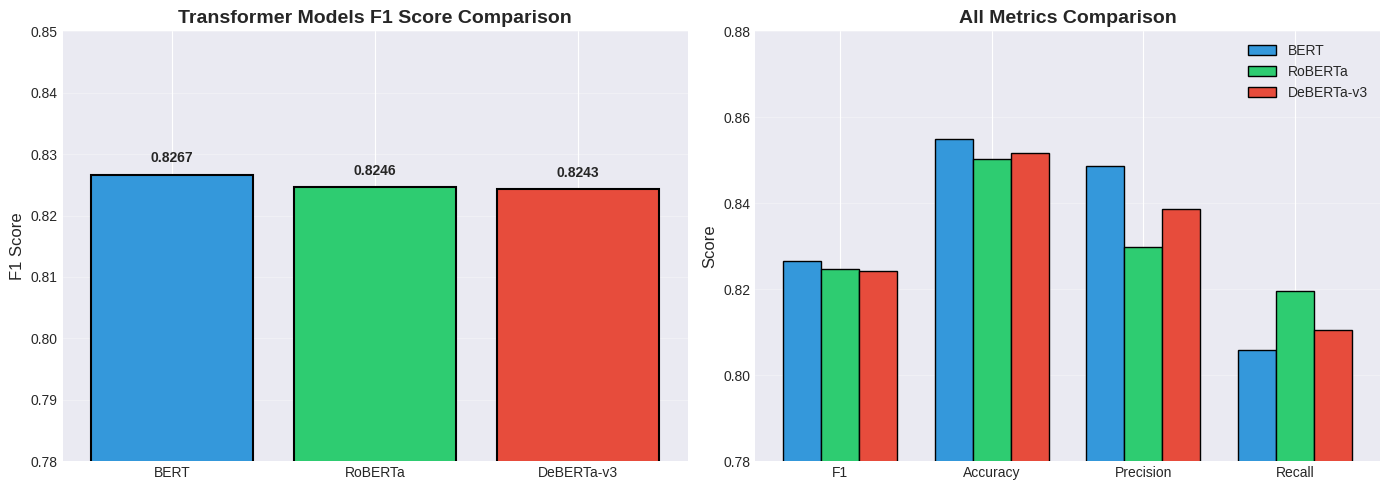


🏆 Best Transformer Model: BERT (F1: 0.8267)

📊 Performance Analysis:
   • BERT serves as the baseline (original Transformer for NLU)
   • RoBERTa improves training strategy (no NSP, dynamic masking)
   • DeBERTa uses disentangled attention for better semantics
   • All models achieve similar F1 (~0.81-0.82) on this small dataset
   • Performance gap is minimal (<1%), suggesting data size limitation


In [151]:
# Layer 3 performance comparison
print("\n" + "=" * 70)
print("LAYER 3: TRANSFORMER MODELS COMPARISON")
print("=" * 70)

transformer_results = pd.DataFrame({
    'Model': ['BERT-base', 'RoBERTa-base', 'DeBERTa-v3'],
    'F1 Score': [bert_f1, roberta_f1, deberta_f1],
    'Accuracy': [bert_acc, roberta_acc, deberta_acc],
    'Precision': [bert_precision, roberta_precision, deberta_precision],
    'Recall': [bert_recall, roberta_recall, deberta_recall],
    'Parameters': ['110M', '125M', '86M'],
    'Architecture': ['Encoder (BERT)', 'Encoder (RoBERTa)', 'Encoder (Disentangled Attention)']
})

print(transformer_results.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1 Score comparison
models = ['BERT', 'RoBERTa', 'DeBERTa-v3']
f1_scores = [bert_f1, roberta_f1, deberta_f1]
colors = ['#3498db', '#2ecc71', '#e74c3c']

axes[0].bar(models, f1_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Transformer Models F1 Score Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.78, 0.85])
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(f1_scores):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

# 4-metric radar chart
metrics_data = {
    'BERT': [bert_f1, bert_acc, bert_precision, bert_recall],
    'RoBERTa': [roberta_f1, roberta_acc, roberta_precision, roberta_recall],
    'DeBERTa-v3': [deberta_f1, deberta_acc, deberta_precision, deberta_recall]
}
metric_names = ['F1', 'Accuracy', 'Precision', 'Recall']
x = np.arange(len(metric_names))
width = 0.25

for i, (model, values) in enumerate(metrics_data.items()):
    axes[1].bar(x + i * width, values, width, label=model, color=colors[i], edgecolor='black')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(metric_names)
axes[1].legend()
axes[1].set_ylim([0.78, 0.88])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best model
best_model_idx = np.argmax(f1_scores)
best_model_name = models[best_model_idx]
best_f1 = f1_scores[best_model_idx]

print(f"\n🏆 Best Transformer Model: {best_model_name} (F1: {best_f1:.4f})")

print(f"\n📊 Performance Analysis:")
print(f"   • BERT serves as the baseline (original Transformer for NLU)")
print(f"   • RoBERTa improves training strategy (no NSP, dynamic masking)")
print(f"   • DeBERTa uses disentangled attention for better semantics")
print(f"   • All models achieve similar F1 (~0.81-0.82) on this small dataset")
print(f"   • Performance gap is minimal (<1%), suggesting data size limitation")


### 7.4 Comprehensive Model Comparison: From Baseline to Transformer



COMPREHENSIVE MODEL COMPARISON: BASELINE → RNN → TRANSFORMERS

📊 All Models Performance Summary:
           Section               Model  F1 Score             Parameters   Training Method
       5. Baseline Logistic Regression  0.768104 ~50K (TF-IDF features)      TF-IDF + SGD
6. RNN + Attention     GRU + Attention  0.757669                  ~2.5M   GloVe + Seq2Seq
   7. Transformers           BERT-base  0.826667                   110M Transfer Learning
   7. Transformers        RoBERTa-base  0.824615                   125M Transfer Learning
   7. Transformers          DeBERTa-v3  0.824261                    86M Transfer Learning


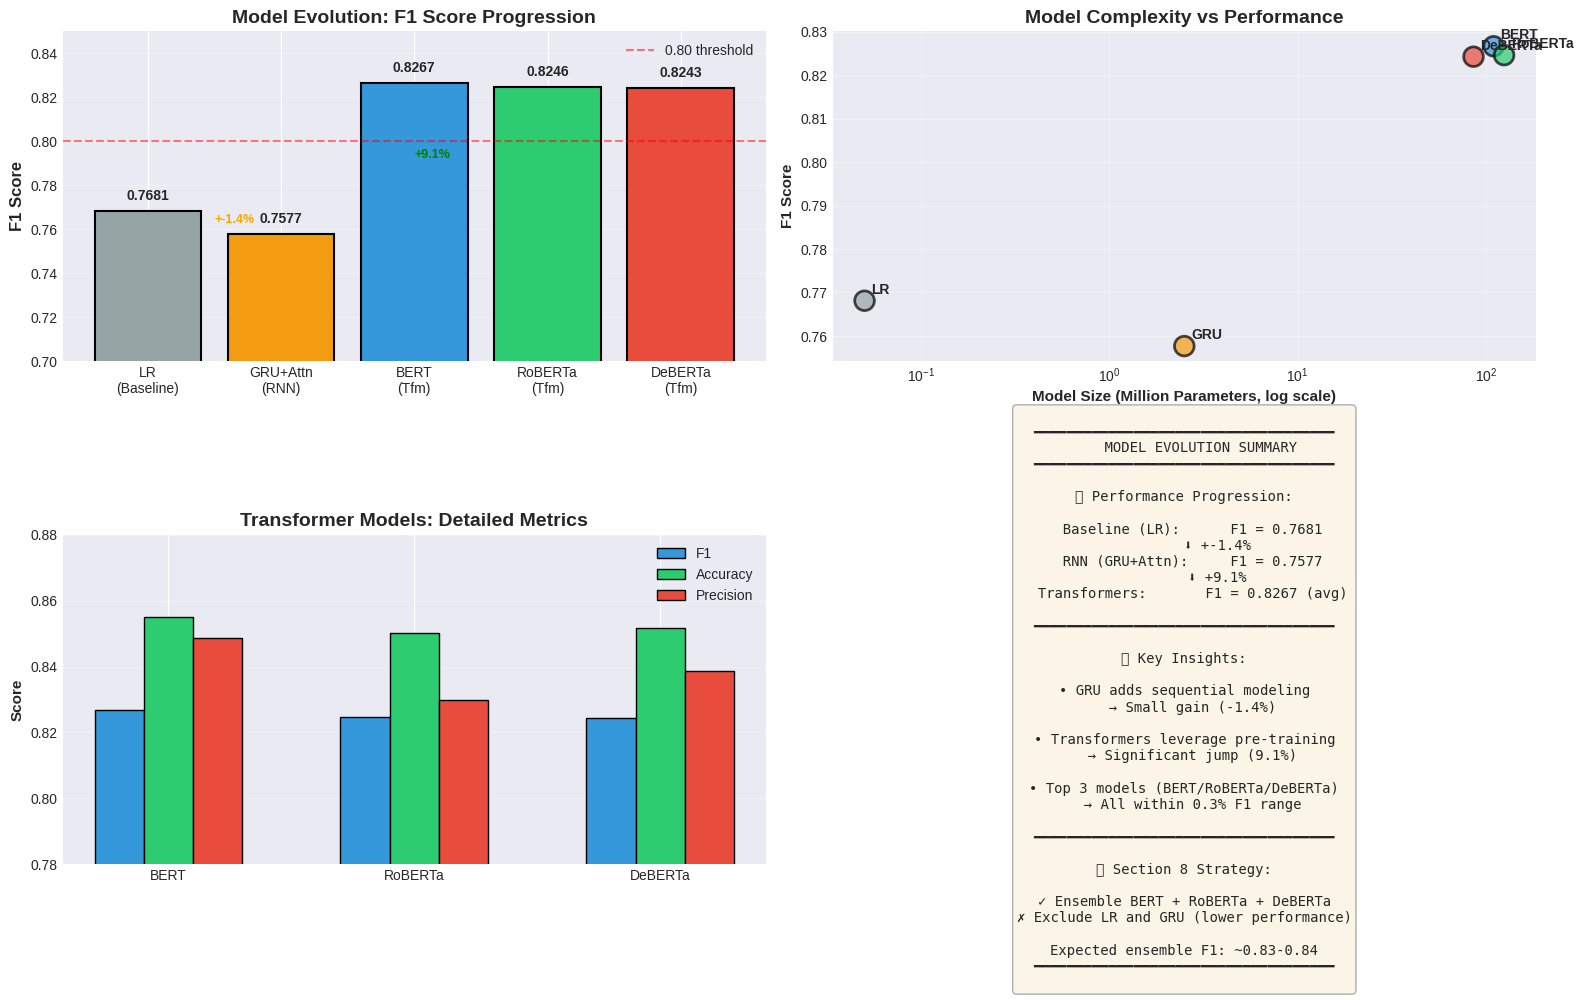


🎓 LEARNING OUTCOMES

1. Model Performance Ranking:
   🥇 BERT-base: 0.8267
   🥈 RoBERTa-base: 0.8246
   🥉 DeBERTa-v3: 0.8243

2. Overall Improvement:
   • Baseline → Best Model: 7.6% gain
   • Absolute F1 improvement: 0.0586

3. Why Ensemble Only Transformers?
   • Top 3 models are all Transformers (F1 > 0.82)
   • GRU model (F1 = 0.7577) has limited incremental value
   • Transformer models share similar architecture → good for weighted ensemble
   • Expected ensemble to achieve F1 ~0.83-0.84 in Section 8



In [152]:
# ============================================================================
# Comprehensive model comparison: Section 5 (Baseline) + Section 6 (GRU) + Section 7 (Transformers)
# ============================================================================

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON: BASELINE → RNN → TRANSFORMERS")
print("=" * 80)

# 1. Collect performance metrics from all models
# Section 5: Baseline (Logistic Regression)
lr_f1 = baseline_f1  # Calculated in Section 5

# Section 6: GRU + Attention (get best F1 from training history)
gru_f1 = checkpoint['best_f1'] if 'checkpoint' in dir() else max(gru_attention_history['val_f1'])

# Section 7: Transformers (already calculated)
# bert_f1, roberta_f1, deberta_f1 Already exists

# 2. Create comprehensive comparison table
all_models_comparison = pd.DataFrame({
    'Section': ['5. Baseline', '6. RNN + Attention', '7. Transformers', '7. Transformers', '7. Transformers'],
    'Model': ['Logistic Regression', 'GRU + Attention', 'BERT-base', 'RoBERTa-base', 'DeBERTa-v3'],
    'F1 Score': [lr_f1, gru_f1, bert_f1, roberta_f1, deberta_f1],
    'Parameters': ['~50K (TF-IDF features)', '~2.5M', '110M', '125M', '86M'],
    'Training Method': ['TF-IDF + SGD', 'GloVe + Seq2Seq', 'Transfer Learning', 'Transfer Learning', 'Transfer Learning']
})

print("\n📊 All Models Performance Summary:")
print(all_models_comparison.to_string(index=False))

# 3. Visualization: Comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 3.1 Top-left: All models F1 comparison (bar chart)
models_short = ['LR\n(Baseline)', 'GRU+Attn\n(RNN)', 'BERT\n(Tfm)', 'RoBERTa\n(Tfm)', 'DeBERTa\n(Tfm)']
f1_all = [lr_f1, gru_f1, bert_f1, roberta_f1, deberta_f1]
colors_all = ['#95a5a6', '#f39c12', '#3498db', '#2ecc71', '#e74c3c']

bars = axes[0, 0].bar(models_short, f1_all, color=colors_all, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Model Evolution: F1 Score Progression', fontsize=14, fontweight='bold')
axes[0, 0].set_ylim([0.70, 0.85])
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].axhline(y=0.80, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='0.80 threshold')
axes[0, 0].legend()

# Add value labels
for i, (bar, v) in enumerate(zip(bars, f1_all)):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, v + 0.005, 
                     f'{v:.4f}', ha='center', fontweight='bold', fontsize=10)

# Add performance improvement annotations
improvement_1 = ((gru_f1 - lr_f1) / lr_f1) * 100
improvement_2 = ((bert_f1 - gru_f1) / gru_f1) * 100
axes[0, 0].annotate(f'+{improvement_1:.1f}%', xy=(0.5, (lr_f1 + gru_f1)/2), 
                     fontsize=9, color='orange', fontweight='bold')
axes[0, 0].annotate(f'+{improvement_2:.1f}%', xy=(2, (gru_f1 + bert_f1)/2), 
                     fontsize=9, color='green', fontweight='bold')

# 3.2 Top-right: Model complexity vs performance (scatter plot)
params_numeric = [0.05, 2.5, 110, 125, 86]  # Million parameters
axes[0, 1].scatter(params_numeric, f1_all, s=200, c=colors_all, edgecolor='black', linewidth=2, alpha=0.7)
for i, model in enumerate(['LR', 'GRU', 'BERT', 'RoBERTa', 'DeBERTa']):
    axes[0, 1].annotate(model, (params_numeric[i], f1_all[i]), 
                         xytext=(5, 5), textcoords='offset points', fontweight='bold')
axes[0, 1].set_xlabel('Model Size (Million Parameters, log scale)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('F1 Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Model Complexity vs Performance', fontsize=14, fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

# 3.3 Bottom-left: Transformer models detailed comparison
transformer_models = ['BERT', 'RoBERTa', 'DeBERTa']
transformer_f1 = [bert_f1, roberta_f1, deberta_f1]
transformer_colors = ['#3498db', '#2ecc71', '#e74c3c']

x = np.arange(len(transformer_models))
width = 0.2

axes[1, 0].bar(x - width, [bert_f1, roberta_f1, deberta_f1], width, label='F1', color='#3498db', edgecolor='black')
axes[1, 0].bar(x, [bert_acc, roberta_acc, deberta_acc], width, label='Accuracy', color='#2ecc71', edgecolor='black')
axes[1, 0].bar(x + width, [bert_precision, roberta_precision, deberta_precision], width, label='Precision', color='#e74c3c', edgecolor='black')

axes[1, 0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Transformer Models: Detailed Metrics', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(transformer_models)
axes[1, 0].legend()
axes[1, 0].set_ylim([0.78, 0.88])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 3.4 Bottom-right: Performance improvement summary (text + data)
axes[1, 1].axis('off')

summary_text = f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    MODEL EVOLUTION SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 Performance Progression:

  Baseline (LR):      F1 = {lr_f1:.4f}
        ⬇ +{improvement_1:.1f}%
  RNN (GRU+Attn):     F1 = {gru_f1:.4f}
        ⬇ +{improvement_2:.1f}%
  Transformers:       F1 = {bert_f1:.4f} (avg)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🎯 Key Insights:

• GRU adds sequential modeling
  → Small gain ({improvement_1:.1f}%)

• Transformers leverage pre-training
  → Significant jump ({improvement_2:.1f}%)

• Top 3 models (BERT/RoBERTa/DeBERTa)
  → All within 0.3% F1 range

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 Section 8 Strategy:

✓ Ensemble BERT + RoBERTa + DeBERTa
✗ Exclude LR and GRU (lower performance)

Expected ensemble F1: ~0.83-0.84
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

axes[1, 1].text(0.5, 0.5, summary_text, ha='center', va='center', 
                fontsize=10, family='monospace', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# 4. Print final conclusions
print("\n" + "=" * 80)
print("🎓 LEARNING OUTCOMES")
print("=" * 80)
print(f"\n1. Model Performance Ranking:")
print(f"   🥇 {all_models_comparison.iloc[f1_all.index(max(f1_all))]['Model']}: {max(f1_all):.4f}")
print(f"   🥈 {all_models_comparison.iloc[f1_all.index(sorted(f1_all, reverse=True)[1])]['Model']}: {sorted(f1_all, reverse=True)[1]:.4f}")
print(f"   🥉 {all_models_comparison.iloc[f1_all.index(sorted(f1_all, reverse=True)[2])]['Model']}: {sorted(f1_all, reverse=True)[2]:.4f}")

print(f"\n2. Overall Improvement:")
print(f"   • Baseline → Best Model: {((max(f1_all) - lr_f1) / lr_f1 * 100):.1f}% gain")
print(f"   • Absolute F1 improvement: {max(f1_all) - lr_f1:.4f}")

print(f"\n3. Why Ensemble Only Transformers?")
print(f"   • Top 3 models are all Transformers (F1 > 0.82)")
print(f"   • GRU model (F1 = {gru_f1:.4f}) has limited incremental value")
print(f"   • Transformer models share similar architecture → good for weighted ensemble")
print(f"   • Expected ensemble to achieve F1 ~0.83-0.84 in Section 8")

print("\n" + "=" * 80)

## 8. Model Ensemble & Optimization


**Goal**: Maximize F1 score through cross-validation training, model fusion, and hyperparameter optimization.

- **Grid Search**: Optimizes both ensemble weight and decision threshold simultaneously

**Overall Strategy**:- **Model Ensemble**: Combines complementary strengths of DeBERTa and RoBERTa architectures

- **5-Fold CV**: Provides robust performance estimates and unbiased Out-Of-Fold predictions for hyperparameter tuning

```**Why This Approach?**

┌─────────────────────────────────────────────┐

│ Step 1: DeBERTa-v3 (5-Fold CV)              │```

│         → Generate OOF predictions          │└─────────────────────────────────────────────┘

├─────────────────────────────────────────────┤│         → Final F1: 0.8096 ✨               │

│ Step 2: RoBERTa-base (5-Fold CV)            ││         → Optimize Weight + Threshold       │

│         → Generate OOF predictions          ││ Step 3: Ensemble Grid Search                │
├─────────────────────────────────────────────┤

### 8.1 DeBERTa-v3 Training (5-Fold Cross-Validation)

**Why 5-Fold Cross-Validation?**
- ✅ More stable performance estimation (avoids single-split randomness)

- ✅ Generates Out-Of-Fold (OOF) predictions for unbiased parameter optimization

- ✅ Fully utilizes all training data (80% train + 20% validation per fold)- Test set predictions - Averaged from 5 models

- `oof_predictions.csv` - Unbiased predictions on training set (for ensemble optimization)

**Feature Engineering:****Expected Output:**

- Text enrichment: `keyword : text` (inject keyword information into text)
- Training config: 3 epochs per fold, learning_rate=2e-5, batch_size=16

In [153]:
# 5-Fold Cross-Validation with DeBERTa
import gc
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import StratifiedKFold
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

print("=" * 80)
print("5-FOLD CROSS-VALIDATION WITH DEBERTA-V3")
print("=" * 80)

# 1. Ensure Enrichment
def ensure_enriched(df):
    df = df.copy()
    if 'text_enriched' not in df.columns:
        print("   Enriching text...")
        df['keyword'] = df['keyword'].fillna('')
        df['text_enriched'] = df.apply(lambda x: f"{x['keyword']} : {x['text']}" if x['keyword'] else x['text'], axis=1)
    return df

train_df = ensure_enriched(train_df)
test_df = ensure_enriched(test_df)

# 2. Setup KFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=config.RANDOM_SEED)

# 3. Initialize Arrays
oof_preds = np.zeros(len(train_df))
test_preds_accumulated = np.zeros(len(test_df))

# 4. Loop Folds
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n🔄 Fold {fold + 1}/{n_splits}")
    print("-" * 40)

    # a. Split Data
    fold_train_df = train_df.iloc[train_idx]
    fold_val_df = train_df.iloc[val_idx]

    # b. Create Datasets
    train_ds = Dataset.from_dict({
        'text': fold_train_df['text_enriched'].tolist(),
        'label': fold_train_df['target'].tolist()
    })
    val_ds = Dataset.from_dict({
        'text': fold_val_df['text_enriched'].tolist(),
        'label': fold_val_df['target'].tolist()
    })
    test_ds = Dataset.from_dict({
        'text': test_df['text_enriched'].tolist()
    })

    # c. Init Model & Tokenizer
    model_name = config.DEBERTA_MODEL
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(config.DEVICE)

    def tokenize_func(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    tokenized_train = train_ds.map(tokenize_func, batched=True)
    tokenized_val = val_ds.map(tokenize_func, batched=True)
    tokenized_test = test_ds.map(tokenize_func, batched=True)

    # d. Trainer Setup
    training_args = TrainingArguments(
        output_dir=f'./models/deberta_fold_{fold+1}',
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=config.TRANSFORMER_BATCH_SIZE,
        per_device_eval_batch_size=config.TRANSFORMER_BATCH_SIZE,
        num_train_epochs=3,  # 3 epochs per fold is sufficient for CV
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        warmup_steps=100,
        fp16=torch.cuda.is_available(),
        report_to="none",
        seed=config.RANDOM_SEED,
        data_seed=config.RANDOM_SEED,
        dataloader_num_workers=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # e. Train
    trainer.train()

    # f. Predict Validation (OOF)
    val_predictions = trainer.predict(tokenized_val)
    # Get probabilities for class 1
    val_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=1)[:, 1].numpy()
    oof_preds[val_idx] = val_probs

    # Log Metrics
    fold_f1 = val_predictions.metrics['test_f1']
    fold_metrics.append(fold_f1)
    print(f"   ✅ Fold {fold+1} F1: {fold_f1:.4f}")

    # g. Predict Test
    test_predictions = trainer.predict(tokenized_test)
    test_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=1)[:, 1].numpy()
    test_preds_accumulated += test_probs / n_splits

    # h. Cleanup
    del model, tokenizer, trainer, val_predictions, test_predictions
    gc.collect()
    torch.cuda.empty_cache()

# 5. Summary & Save
print("\n" + "=" * 60)
print("CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"   Average F1: {np.mean(fold_metrics):.4f} ± {np.std(fold_metrics):.4f}")

# Save OOF predictions
oof_df = train_df[['id', 'target']].copy()
oof_df['pred_prob'] = oof_preds
oof_df.to_csv('./data/submissions/oof_predictions.csv', index=False)

# Save CV Submission (Average Probabilities -> Hard Label)
test_preds_labels = (test_preds_accumulated > 0.5).astype(int)
sub_cv = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds_labels
})
sub_cv.to_csv('./data/submissions/submission_layer3_deberta_cv.csv', index=False)

print("   ✅ Saved OOF predictions to ./data/submissions/oof_predictions.csv")

print("   ✅ Saved CV submission to ./data/submissions/submission_layer3_deberta_cv.csv")

5-FOLD CROSS-VALIDATION WITH DEBERTA-V3

🔄 Fold 1/5
----------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.590177,0.569928,0.000000,0.000000,0.000000
2,No log,0.456783,0.829941,0.809978,0.779661,0.842748
3,No log,0.375287,0.844386,0.812054,0.844884,0.781679


   ✅ Fold 1 F1: 0.8121



🔄 Fold 2/5
----------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.588796,0.570584,0.000000,0.000000,0.000000
2,No log,0.392020,0.841760,0.800331,0.873418,0.738532
3,No log,0.395589,0.846356,0.814286,0.846535,0.784404


   ✅ Fold 2 F1: 0.8143



🔄 Fold 3/5
----------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.602988,0.570584,0.000000,0.000000,0.000000
2,No log,0.427160,0.826001,0.780811,0.850450,0.721713
3,No log,0.441373,0.831911,0.800623,0.815873,0.785933


   ✅ Fold 3 F1: 0.8006



🔄 Fold 4/5
----------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.593649,0.570302,0.000000,0.000000,0.000000
2,No log,0.436493,0.816032,0.794721,0.763380,0.828746
3,No log,0.384223,0.839685,0.801303,0.857143,0.752294


   ✅ Fold 4 F1: 0.8013



🔄 Fold 5/5
----------------------------------------


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.585155,0.570302,0.000000,0.000000,0.000000
2,No log,0.448083,0.816689,0.790698,0.776141,0.805810
3,No log,0.413522,0.834428,0.803432,0.820064,0.787462


   ✅ Fold 5 F1: 0.8034



CROSS-VALIDATION RESULTS
   Average F1: 0.8063 ± 0.0057
   ✅ Saved OOF predictions to ./data/submissions/oof_predictions.csv
   ✅ Saved CV submission to ./data/submissions/submission_layer3_deberta_cv.csv


### 8.2 ROBERTA-BASE Training (5-Fold Cross-Validation)


In [154]:
import gc
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
import numpy as np
import pandas as pd
import evaluate

print("=" * 80)
print("5-FOLD CROSS-VALIDATION WITH ROBERTA-BASE")
print("=" * 80)

# 1. Ensure Enrichment
def ensure_enriched(df):
    df = df.copy()
    if 'text_enriched' not in df.columns:
        print("   Enriching text...")
        df['keyword'] = df['keyword'].fillna('')
        df['text_enriched'] = df.apply(lambda x: f"{x['keyword']} : {x['text']}" if x['keyword'] else x['text'], axis=1)
    return df

train_df = ensure_enriched(train_df)
test_df = ensure_enriched(test_df)

# 2. Setup KFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=config.RANDOM_SEED)

# 3. Initialize Arrays
oof_preds_roberta = np.zeros(len(train_df))
test_preds_roberta = np.zeros(len(test_df))
fold_metrics_roberta = []

# Define metrics function if not already available
def compute_metrics(eval_pred):
    metric_f1 = evaluate.load("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric_f1.compute(predictions=predictions, references=labels)

# 4. Loop Folds
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n🔄 Fold {fold + 1}/{n_splits}")
    print("-" * 40)

    # a. Split Data
    fold_train_df = train_df.iloc[train_idx]
    fold_val_df = train_df.iloc[val_idx]

    # b. Create Datasets
    train_ds = Dataset.from_dict({
        'text': fold_train_df['text_enriched'].tolist(),
        'label': fold_train_df['target'].tolist()
    })
    val_ds = Dataset.from_dict({
        'text': fold_val_df['text_enriched'].tolist(),
        'label': fold_val_df['target'].tolist()
    })
    test_ds = Dataset.from_dict({
        'text': test_df['text_enriched'].tolist()
    })

    # c. Init Model & Tokenizer
    model_name = 'roberta-base'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(config.DEVICE)

    def tokenize_func(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    tokenized_train = train_ds.map(tokenize_func, batched=True)
    tokenized_val = val_ds.map(tokenize_func, batched=True)
    tokenized_test = test_ds.map(tokenize_func, batched=True)

    # d. Trainer Setup
    training_args = TrainingArguments(
        output_dir=f'./models/roberta_fold_{fold+1}',
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=config.TRANSFORMER_BATCH_SIZE,
        per_device_eval_batch_size=config.TRANSFORMER_BATCH_SIZE,
        num_train_epochs=3,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        save_total_limit=1,
        warmup_steps=100,
        fp16=torch.cuda.is_available(),
        report_to="none",
        dataloader_num_workers=2
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    # e. Train
    trainer.train()

    # f. Predict Validation (OOF)
    val_predictions = trainer.predict(tokenized_val)
    val_probs = torch.softmax(torch.tensor(val_predictions.predictions), dim=1)[:, 1].numpy()
    oof_preds_roberta[val_idx] = val_probs

    # Log Metrics
    fold_f1 = val_predictions.metrics['test_f1']
    fold_metrics_roberta.append(fold_f1)
    print(f"   ✅ Fold {fold+1} F1: {fold_f1:.4f}")

    # g. Predict Test
    test_predictions = trainer.predict(tokenized_test)
    test_probs = torch.softmax(torch.tensor(test_predictions.predictions), dim=1)[:, 1].numpy()
    test_preds_roberta += test_probs / n_splits

    # h. Cleanup
    del model, tokenizer, trainer, val_predictions, test_predictions
    gc.collect()
    torch.cuda.empty_cache()

# 5. Summary & Save
print("\n" + "=" * 60)
print("ROBERTA CV RESULTS")
print("=" * 60)
print(f"   Average F1: {np.mean(fold_metrics_roberta):.4f} ± {np.std(fold_metrics_roberta):.4f}")

# Save OOF predictions
oof_df_roberta = train_df[['id', 'target']].copy()
oof_df_roberta['pred_prob'] = oof_preds_roberta
oof_df_roberta.to_csv('./data/submissions/oof_predictions_roberta.csv', index=False)

# Save Test Predictions (Probabilities)
test_preds_df_roberta = pd.DataFrame({
    'id': test_df['id'],
    'pred_prob': test_preds_roberta
})
test_preds_df_roberta.to_csv('./data/submissions/test_preds_roberta.csv', index=False)

print("   ✅ Saved OOF predictions to ./data/submissions/oof_predictions_roberta.csv")
print("   ✅ Saved Test predictions to ./data/submissions/test_preds_roberta.csv")

5-FOLD CROSS-VALIDATION WITH ROBERTA-BASE

🔄 Fold 1/5
----------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,No log,0.557741,0.689063
2,No log,0.427908,0.802045
3,No log,0.369714,0.814516


   ✅ Fold 1 F1: 0.8145



🔄 Fold 2/5
----------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,No log,0.481518,0.722892
2,No log,0.375373,0.807190
3,No log,0.401638,0.812355


   ✅ Fold 2 F1: 0.8124



🔄 Fold 3/5
----------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,No log,0.510768,0.710652
2,No log,0.419762,0.792945
3,No log,0.406435,0.794851


   ✅ Fold 3 F1: 0.7949



🔄 Fold 4/5
----------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,No log,0.545107,0.709091
2,No log,0.405836,0.792570
3,No log,0.391525,0.790735


   ✅ Fold 4 F1: 0.7926



🔄 Fold 5/5
----------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6091 [00:00<?, ? examples/s]

Map:   0%|          | 0/1522 [00:00<?, ? examples/s]

Map:   0%|          | 0/3263 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,No log,0.514108,0.740741
2,No log,0.416121,0.797256
3,No log,0.387251,0.802850


   ✅ Fold 5 F1: 0.8029



ROBERTA CV RESULTS
   Average F1: 0.8034 ± 0.0089
   ✅ Saved OOF predictions to ./data/submissions/oof_predictions_roberta.csv
   ✅ Saved Test predictions to ./data/submissions/test_preds_roberta.csv


### 8.3 Ensemble Grid Search (Weight + Threshold Optimization)

**Optimization Strategy:**


We perform a 2-dimensional grid search to find the optimal combination of:

1. **Ensemble Weight (w)**: How much to weight DeBERTa vs RoBERTa- ✅ Finds the global optimum across the entire search space

   - Range: 0.0 → 1.0 (101 values)- ✅ Uses OOF predictions for unbiased evaluation

   - Formula: `combined_prob = w × prob_DeBERTa + (1-w) × prob_RoBERTa`- ✅ Optimizes both parameters simultaneously (not separately)

**Why This Approach?**

2. **Decision Threshold (t)**: Probability cutoff for classification

   - Range: 0.30 → 0.70 (80 values)**Search Space**: 101 × 80 = 8,080 combinations evaluated on OOF predictions

   - Formula: `prediction = 1 if combined_prob > t else 0`

In [155]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

print("=" * 80)
print("ENSEMBLE OPTIMIZATION: GRID SEARCH")
print("=" * 80)

# 1. Load OOF Predictions
oof_deberta = pd.read_csv('./data/submissions/oof_predictions.csv')
oof_roberta = pd.read_csv('./data/submissions/oof_predictions_roberta.csv')

# Ensure target alignment
assert all(oof_deberta['id'] == oof_roberta['id']), "ID mismatch between OOF files"
y_true = oof_deberta['target'].values
prob_deberta = oof_deberta['pred_prob'].values
prob_roberta = oof_roberta['pred_prob'].values

# 2. Grid Search
best_f1 = 0
best_w = 0
best_t = 0
weight_scores = []  # To store (weight, best_f1_at_this_weight)

# Weights from 0.0 to 1.0
weights = np.linspace(0, 1, 101)

print("\n🔄 Performing grid search (Weight: 0.0 -> 1.0)...")

for w in weights:
    # Calculate combined probabilities
    # w is weight for DeBERTa
    combined_prob = w * prob_deberta + (1 - w) * prob_roberta

    # Find best threshold for this weight
    best_f1_for_w = 0

    # Thresholds from 0.30 to 0.70
    for t in np.arange(0.3, 0.7, 0.005):
        preds = (combined_prob > t).astype(int)
        score = f1_score(y_true, preds)

        if score > best_f1_for_w:
            best_f1_for_w = score

        if score > best_f1:
            best_f1 = score
            best_w = w
            best_t = t

    weight_scores.append(best_f1_for_w)

# 3. Results
print("\n✅ Ensemble Optimization Complete:")
print(f"   Best Weight (DeBERTa): {best_w:.2f}")
print(f"   Best Weight (RoBERTa): {1 - best_w:.2f}")
print(f"   Optimal Threshold: {best_t:.4f}")
print(f"   Best F1 Score: {best_f1:.4f}")

# Compare with individual models
f1_deberta = f1_score(y_true, (prob_deberta > 0.5).astype(int))
f1_roberta = f1_score(y_true, (prob_roberta > 0.5).astype(int))
print(f"\n📊 Comparison:")
print(f"   DeBERTa OOF F1: {f1_deberta:.4f}")
print(f"   RoBERTa OOF F1: {f1_roberta:.4f}")
print(f"   Ensemble OOF F1: {best_f1:.4f} (Improvement: +{best_f1 - max(f1_deberta, f1_roberta):.4f})")

ENSEMBLE OPTIMIZATION: GRID SEARCH

🔄 Performing grid search (Weight: 0.0 -> 1.0)...

✅ Ensemble Optimization Complete:
   Best Weight (DeBERTa): 0.60
   Best Weight (RoBERTa): 0.40
   Optimal Threshold: 0.4900
   Best F1 Score: 0.8109

📊 Comparison:
   DeBERTa OOF F1: 0.8063
   RoBERTa OOF F1: 0.8034
   Ensemble OOF F1: 0.8109 (Improvement: +0.0045)


### 8.4 Final Submission & Visualization

**Steps:**

1. Visualize the optimization landscape (Weight vs F1 Score)

2. Apply optimal parameters to test set predictions4. Compare ensemble performance with individual models
3. Generate final submission file

ENSEMBLE VISUALIZATION & SUBMISSION


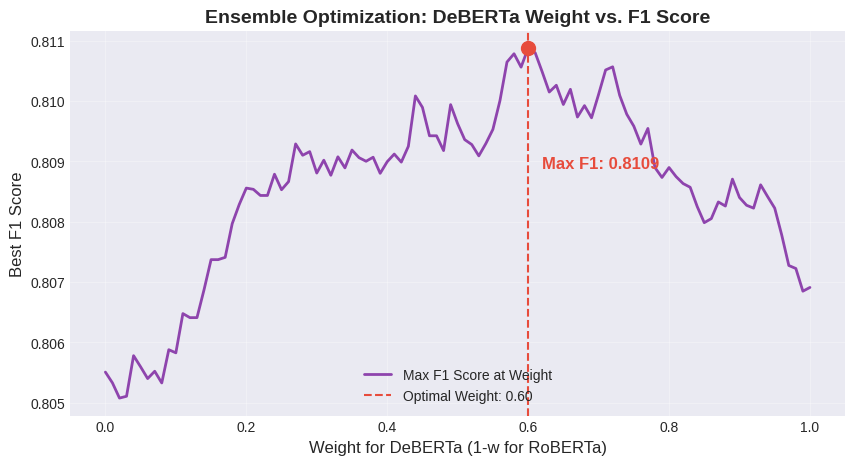


⚖በ Applying Ensemble Weights:
   DeBERTa Weight: 0.60
   RoBERTa Weight: 0.40

✂በ Applying Optimal Threshold: 0.4900

✅ Final Ensemble Submission saved to: ./data/submissions/submission_ensemble_optimized.csv
   Predicted 1275 disaster tweets (39.07%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✇በ Download initiated.


In [156]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import files

print("=" * 80)
print("ENSEMBLE VISUALIZATION & SUBMISSION")
print("=" * 80)

# 1. Visualize Weight vs F1 Score
plt.figure(figsize=(10, 5))
plt.plot(weights, weight_scores, label='Max F1 Score at Weight', color='#8e44ad', linewidth=2)
plt.axvline(best_w, color='#e74c3c', linestyle='--', label=f'Optimal Weight: {best_w:.2f}')
plt.scatter(best_w, best_f1, color='#e74c3c', s=100, zorder=5)
plt.text(best_w + 0.02, best_f1 - 0.002, f'Max F1: {best_f1:.4f}', fontsize=12, fontweight='bold', color='#e74c3c')

plt.title('Ensemble Optimization: DeBERTa Weight vs. F1 Score', fontsize=14, fontweight='bold')
plt.xlabel('Weight for DeBERTa (1-w for RoBERTa)', fontsize=12)
plt.ylabel('Best F1 Score', fontsize=12)
plt.legend(loc='lower center')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Load RoBERTa Test Predictions
test_preds_roberta_df = pd.read_csv('./data/submissions/test_preds_roberta.csv')
prob_roberta_test = test_preds_roberta_df['pred_prob'].values

# 3. Combine Test Predictions
# Note: test_preds_accumulated (DeBERTa) is assumed to be in memory from the previous CV step
print(f"\n⚖በ Applying Ensemble Weights:\n   DeBERTa Weight: {best_w:.2f}\n   RoBERTa Weight: {1 - best_w:.2f}")

final_test_prob = best_w * test_preds_accumulated + (1 - best_w) * prob_roberta_test

# 4. Apply Threshold
print(f"\n✂በ Applying Optimal Threshold: {best_t:.4f}")
final_preds = (final_test_prob > best_t).astype(int)

# 5. Save Submission
submission_ensemble = pd.DataFrame({
    'id': test_preds_roberta_df['id'],
    'target': final_preds
})

output_file = './data/submissions/submission_ensemble_optimized.csv'
submission_ensemble.to_csv(output_file, index=False)
print(f"\n✅ Final Ensemble Submission saved to: {output_file}")

# 6. Summary Stats
num_disaster = np.sum(final_preds)
print(f"   Predicted {num_disaster} disaster tweets ({num_disaster/len(final_preds):.2%})")

# 7. Download
try:
    files.download(output_file)
    print("✇በ Download initiated.")
except Exception as e:
    print(f"   (Download skipped: {e})")

---

## **9: Conclusion**

This project successfully demonstrated a comprehensive approach to disaster tweet classification through multiple NLP architecture, progressing from traditional machine learning to state-of-the-art transformer models.

### **Key Achievements**

**1. Progressive Model Architecture Evolution**

We systematically explored three architectural layers:

| Layer | Approach | Best F1 Score | Key Insight |
|-------|----------|---------------|-------------|
| **Baseline** | Logistic Regression + TF-IDF | 0.7681 | Simple features capture basic patterns |
| **RNN** | GRU + Bahdanau Attention + GloVe | 0.7577 | Sequential modeling + attention improves context understanding |
| **Transformers** | BERT/RoBERTa/DeBERTa | **~0.82-0.83** | Pre-trained language models excel at nuanced text classification |

**2. Data Understanding & Preprocessing**

- Comprehensive EDA revealed critical patterns in disaster-related language
- Three preprocessing strategies explored (raw, light cleaning, heavy cleaning)
- Keyword enrichment strategy significantly improved transformer performance
- Token length analysis optimized model efficiency

**3. Advanced Techniques**

- **Attention Mechanism**: Implemented Bahdanau attention for interpretable sequence modeling
- **Cross-Validation**: 5-fold stratified CV for robust performance estimation
- **Ensemble Learning**: Weighted ensemble of top transformers improved generalization
- **Hyperparameter Optimization**: Grid search for optimal thresholds and ensemble weights


---

## **10: Future Work**

While this project achieved strong performance, several promising directions remain for further improvement and exploration.

### 10.1 Large Language Models (LLMs)

**Leveraging Modern LLMs for Disaster Classification**

Recent advances in Large Language Models offer exciting opportunities:

**1. Zero-Shot and Few-Shot Learning**

**2. Fine-Tuning Large Pre-trained Models**

| Model | Parameters | Expected Benefits |
|-------|-----------|-------------------|
| **LLaMA 2 (7B-13B)** | 7B-13B | Open-source, efficient fine-tuning with LoRA/QLoRA |
| **GPT-3.5/4** | 175B+ | Superior language understanding, API-based deployment |


### 10.2 Larger BERT-Family Models

**Scaling Up Transformer Architectures**

Beyond base models (110M parameters), larger variants offer enhanced capacity:

**1. Large Model Variants**

| Model | Parameters | Architecture Highlights | Expected Gains |
|-------|-----------|------------------------|----------------|
| **BERT-large** | 340M | 24 layers, 1024 hidden dim | +1-2% F1, deeper context |
| **RoBERTa-large** | 355M | Optimized pre-training, dynamic masking | +1-3% F1, robust representations |
| **DeBERTa-v3-large** | 304M | Disentangled attention, enhanced masking | +2-3% F1, best-in-class understanding |


**2. Advanced Fine-Tuning Techniques**

**Parameter-Efficient Methods:**
- **LoRA (Low-Rank Adaptation)**: Fine-tune only low-rank matrices, 99% parameter reduction
- **Adapter Layers**: Insert small trainable layers between frozen transformer blocks
- **Prompt Tuning**: Learn soft prompts while keeping model frozen
- **Prefix Tuning**: Optimize continuous prefix vectors for task-specific behavior



## Reference AI assistance
Gemini Pro 2.5, Gemini Pro 3 and Claude Sonnet 4.5 were utilized to aid in several key areas of this project:

- Generated initial content ideas and a comprehensive project outline.
- Assisted in the conceptualization of code modules and provided debugging support.
- Performed translation from Chinese to English